### Download and Unzip Data

This cell downloads a zipped data file from Google Drive and then unzips it into the `/content/Data` directory. This is the first step to access the raw datasets for the project.

In [3]:
!pip install gdown

In [4]:
!gdown 158UsTFslelLvMVwCo4zTIxVZ1mnIx6hI

Downloading...
From (original): https://drive.google.com/uc?id=158UsTFslelLvMVwCo4zTIxVZ1mnIx6hI
From (redirected): https://drive.google.com/uc?id=158UsTFslelLvMVwCo4zTIxVZ1mnIx6hI&confirm=t&uuid=2df2cd10-a8de-4f6e-93df-cfde5253f7be
To: C:\Users\JAY\Downloads\Data.zip

  0%|          | 0.00/2.02G [00:00<?, ?B/s]
  0%|          | 524k/2.02G [00:00<17:43, 1.90MB/s]
  0%|          | 1.05M/2.02G [00:00<14:52, 2.27MB/s]
  0%|          | 1.57M/2.02G [00:00<13:29, 2.50MB/s]
  0%|          | 2.10M/2.02G [00:00<11:49, 2.85MB/s]
  0%|          | 2.62M/2.02G [00:00<10:40, 3.16MB/s]
  0%|          | 3.15M/2.02G [00:01<09:53, 3.41MB/s]
  0%|          | 3.67M/2.02G [00:01<09:35, 3.51MB/s]
  0%|          | 4.19M/2.02G [00:01<09:03, 3.72MB/s]
  0%|          | 4.72M/2.02G [00:01<08:32, 3.94MB/s]
  0%|          | 5.24M/2.02G [00:01<08:08, 4.14MB/s]
  0%|          | 6.29M/2.02G [00:01<06:57, 4.83MB/s]
  0%|          | 7.34M/2.02G [00:01<06:28, 5.20MB/s]
  0%|          | 8.39M/2.02G [00:02<06:22, 5.27MB/s

### Unzip Downloaded Data

This cell unzips the `Data.zip` file downloaded in the previous step. The extracted files contain various datasets related to player and team statistics.

In [2]:
!unzip Data.zip

Archive:  Data.zip
 extracting: Data/API Player Season Stats v4.0.0 (1).pdf  
 extracting: Data/Match Level Data/API Events v8.0.0 (1).pdf  
 extracting: Data/Match Level Data/API Player Match Stats v5.0.0 (1).pdf  
 extracting: Data/Match Level Data/API Player Season Stats v4.0.0 (1).pdf  
 extracting: Data/Match Level Data/API Team Match Stats v1.0.0 (1).pdf  
 extracting: Data/Match Level Data/matches_info_ccfc.csv  
 extracting: Data/Match Level Data/matches_info_lcfc.csv  
 extracting: Data/Match Level Data/physical_player_match_stats.csv  
 extracting: Data/Match Level Data/player_match_stats_ccfc.csv  
 extracting: Data/Match Level Data/player_match_stats_lcfc.csv  
 extracting: Data/Match Level Data/team_match_stats.csv  
 extracting: Data/L1Champcombined_data.xlsx  
 extracting: Data/player_season_stats.csv  


### Garbage Collection

This cell explicitly calls the Python garbage collector to free up memory. This is a good practice, especially when dealing with large datasets, to manage memory usage effectively.

In [3]:
import gc; gc.collect()

0

### Initial Feature Engineering Pipeline (with Memory Optimization)

This cell defines and runs the initial feature engineering pipeline. It loads multiple datasets, identifies the target variable, creates base features, processes match-level data in chunks for memory efficiency, creates team context features, integrates all features, handles missing values, and selects features. The goal is to prepare a dataset for predicting player minutes.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import gc
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression
import plotly.express as px
import plotly.graph_objects as go
import warnings
import gc
import psutil
import os

# Memory monitoring function
def check_memory():
    process = psutil.Process(os.getpid())
    memory_gb = process.memory_info().rss / 1024**3
    print(f"💾 Current memory usage: {memory_gb:.2f} GB")
    return memory_gb

warnings.filterwarnings('ignore')

print("=== PLAYER MINUTES PREDICTION - FEATURE ENGINEERING PIPELINE ===")
print("="*75)

# 1. DATA LOADING AND INTEGRATION SETUP
print("\n1. DATA LOADING AND INTEGRATION SETUP")
print("-" * 50)

class FeatureEngineeringPipeline:
    """
    Comprehensive Feature Engineering Pipeline for Player Minutes Prediction
    """

    def __init__(self):
        self.target_column = 'player_season_minutes'
        self.feature_metadata = {}
        self.engineered_features = []
        self.league_one_teams = []  # Will be populated
        self.championship_teams = []  # Will be populated

    def load_all_datasets(self, encoding='iso-8859-1'):
        """Load and perform initial processing of all datasets"""

        print("📂 Loading all datasets...")

        try:
            # 1. Season-level player data (main dataset)
            print("   Loading player_season_stats.csv...")
            self.player_season = pd.read_csv('/content/Data/player_season_stats.csv',
                                           encoding=encoding, low_memory=False)
            print(f"   ✅ Player season data: {self.player_season.shape}")

            # 2. Lincoln City match data (League One)
            print("   Loading player_match_stats_lcfc.csv...")
            self.lcfc_matches = pd.read_csv('/content/Data/Match Level Data/player_match_stats_lcfc.csv',
                                          encoding=encoding, low_memory=False)
            print(f"   ✅ LCFC match data: {self.lcfc_matches.shape}")

            # 3. Coventry City match data (Championship)
            print("   Loading player_match_stats_ccfc.csv...")
            self.ccfc_matches = pd.read_csv('/content/Data/Match Level Data/player_match_stats_ccfc.csv',
                                          encoding=encoding, low_memory=False)
            print(f"   ✅ CCFC match data: {self.ccfc_matches.shape}")

            # 4. Team-level data
            print("   Loading L1Champcombined_data.xlsx...")
            self.team_data = pd.read_excel('/content/Data/L1Champcombined_data.xlsx')
            print(f"   ✅ Team data: {self.team_data.shape}")

            print("✅ All datasets loaded successfully!")

        except Exception as e:
            print(f"❌ Error loading datasets: {e}")
            raise

    def identify_target_variable(self):
        """Identify and validate target variable"""

        print("\n2. TARGET VARIABLE IDENTIFICATION")
        print("-" * 45)

        if self.target_column in self.player_season.columns:
            print(f"✅ Target variable found: {self.target_column}")

            target_stats = self.player_season[self.target_column].describe()
            print(f"📊 Target statistics:")
            print(f"   Count: {target_stats['count']:,.0f}")
            print(f"   Mean: {target_stats['mean']:.1f} minutes")
            print(f"   Median: {target_stats['50%']:.1f} minutes")
            print(f"   Std: {target_stats['std']:.1f} minutes")
            print(f"   Range: {target_stats['min']:.1f} - {target_stats['max']:.1f} minutes")

            # Check for missing values
            missing_target = self.player_season[self.target_column].isnull().sum()
            print(f"   Missing values: {missing_target} ({missing_target/len(self.player_season)*100:.1f}%)")

            return True
        else:
            print(f"❌ Target variable '{self.target_column}' not found")
            available_cols = [col for col in self.player_season.columns if 'minute' in col.lower()]
            print(f"Available minute columns: {available_cols}")
            return False

    def create_base_features(self):
        """Create base features from season-level data"""

        print("\n3. BASE FEATURE ENGINEERING")
        print("-" * 40)

        df = self.player_season.copy()

        # Age calculation
        if 'birth_date' in df.columns:
            print("👤 Engineering age features...")
            df['birth_date'] = pd.to_datetime(df['birth_date'], errors='coerce')
            reference_date = pd.to_datetime('2024-01-01')
            df['age'] = (reference_date - df['birth_date']).dt.days / 365.25

            # Age categories
            df['age_group'] = pd.cut(df['age'],
                                   bins=[0, 20, 23, 26, 30, 35, 50],
                                   labels=['Youth', 'Young', 'Prime', 'Experienced', 'Veteran', 'Senior'])

            # Age-related features
            df['is_young_player'] = (df['age'] <= 23).astype(int)
            df['is_veteran'] = (df['age'] >= 30).astype(int)
            df['age_squared'] = df['age'] ** 2

            print(f"   ✅ Age features created (range: {df['age'].min():.1f} - {df['age'].max():.1f})")

        # Position encoding
        if 'primary_position' in df.columns:
            print("⚽ Engineering position features...")

            # Clean position data
            df['primary_position_clean'] = df['primary_position'].fillna('Unknown')

            # Position groups
            position_mapping = {
                'Goalkeeper': 'GK',
                'Centre Back': 'DEF', 'Left Back': 'DEF', 'Right Back': 'DEF',
                'Left Centre Back': 'DEF', 'Right Centre Back': 'DEF',
                'Defensive Midfielder': 'MID', 'Central Midfielder': 'MID',
                'Left Midfielder': 'MID', 'Right Midfielder': 'MID',
                'Attacking Midfielder': 'MID', 'Centre Attacking Midfielder': 'MID',
                'Left Winger': 'FWD', 'Right Winger': 'FWD',
                'Striker': 'FWD', 'Centre Forward': 'FWD'
            }

            df['position_group'] = df['primary_position_clean'].map(position_mapping).fillna('OTHER')

            # Position dummy variables
            position_dummies = pd.get_dummies(df['position_group'], prefix='pos')
            df = pd.concat([df, position_dummies], axis=1)

            print(f"   ✅ Position features created: {df['position_group'].value_counts().to_dict()}")

        # Physical attributes
        if 'player_height' in df.columns and 'player_weight' in df.columns:
            print("💪 Engineering physical features...")

            # BMI calculation
            df['bmi'] = df['player_weight'] / ((df['player_height'] / 100) ** 2)

            # Physical categories
            df['height_category'] = pd.cut(df['player_height'],
                                         bins=[0, 170, 180, 190, 220],
                                         labels=['Short', 'Average', 'Tall', 'Very_Tall'])

            df['weight_category'] = pd.cut(df['player_weight'],
                                         bins=[0, 65, 75, 85, 120],
                                         labels=['Light', 'Average', 'Heavy', 'Very_Heavy'])

            print(f"   ✅ Physical features created")

        # Performance efficiency features
        print("📈 Engineering performance efficiency features...")

        # Per 90-minute metrics efficiency
        per_90_cols = [col for col in df.columns if '90' in col and 'player_season' in col]

        for col in per_90_cols[:10]:  # Limit to avoid too many features
            if col in df.columns:
                base_name = col.replace('player_season_', '').replace('_90', '')

                # Create efficiency ratios
                if f'player_season_{base_name}_90' in df.columns and 'player_season_appearances' in df.columns:
                    df[f'{base_name}_efficiency'] = (
                        df[f'player_season_{base_name}_90'] * df['player_season_appearances']
                    )

        # Minutes per appearance
        if 'player_season_appearances' in df.columns:
            df['avg_minutes_per_appearance'] = (
                df[self.target_column] / df['player_season_appearances'].replace(0, np.nan)
            )

            # Player role based on minutes per appearance
            df['player_role'] = pd.cut(df['avg_minutes_per_appearance'],
                                     bins=[0, 30, 60, 85, 120],
                                     labels=['Substitute', 'Rotation', 'Regular', 'Key_Player'])

        print(f"   ✅ Performance features created")

        self.base_features_df = df
        return df

    def create_match_level_features_chunked(self, chunk_size=50000):
        """Create features from match-level data using chunked processing"""
        print("\n4. MATCH-LEVEL FEATURE ENGINEERING (CHUNKED)")
        print("-" * 45)

        # Combine datasets with minimal memory footprint
        print("🔗 Processing match-level datasets in chunks...")

        # Process LCFC matches
        lcfc_features = self._process_match_chunk(self.lcfc_matches, 'League_One', chunk_size)

        # Process CCFC matches
        ccfc_features = self._process_match_chunk(self.ccfc_matches, 'Championship', chunk_size)

        # Combine results
        match_agg_df = pd.concat([lcfc_features, ccfc_features], ignore_index=True)

        print(f" ✅ Match-level features created: {match_agg_df.shape}")
        self.match_features_df = match_agg_df
        return match_agg_df

    def _process_match_chunk(self, match_data, competition, chunk_size):
        """Process match data in chunks to avoid memory issues"""

        # Find minutes column
        minutes_col = 'player_match_minutes' if 'player_match_minutes' in match_data.columns else 'minutes'

        # Essential columns only
        essential_cols = ['player_id', minutes_col]

        # Add performance columns if they exist (limit to most important)
        performance_cols = [col for col in match_data.columns if
                          any(x in col.lower() for x in ['goal', 'assist', 'shot', 'pass'])
                          and match_data[col].dtype in ['int64', 'float64']][:10]

        essential_cols.extend(performance_cols)
        essential_cols = [col for col in essential_cols if col in match_data.columns]

        # Process in chunks
        chunk_results = []
        total_rows = len(match_data)

        for start_idx in range(0, total_rows, chunk_size):
            end_idx = min(start_idx + chunk_size, total_rows)
            chunk = match_data[essential_cols].iloc[start_idx:end_idx].copy()

            # Process this chunk
            chunk_agg = self._aggregate_chunk_features(chunk, minutes_col, performance_cols)
            chunk_results.append(chunk_agg)

            # Clear chunk from memory
            del chunk
            gc.collect()

            if start_idx % (chunk_size * 5) == 0:  # Progress update every 5 chunks
                print(f"   Processed {end_idx:,} / {total_rows:,} rows ({end_idx/total_rows*100:.1f}%)")

        # Combine chunk results
        if chunk_results:
            final_result = pd.concat(chunk_results, ignore_index=True)
            # Group by player_id and aggregate again (in case player appears in multiple chunks)
            final_result = final_result.groupby('player_id').agg({
                col: 'sum' if 'total' in col else 'mean'
                for col in final_result.columns if col != 'player_id'
            }).reset_index()

            final_result['competition_level'] = competition
            return final_result

        return pd.DataFrame()

    def _aggregate_chunk_features(self, chunk, minutes_col, performance_cols):
        """Aggregate features for a single chunk"""

        # Basic aggregations
        agg_dict = {
            minutes_col: ['count', 'sum', 'mean', 'std', 'min', 'max']
        }

        # Add performance columns
        for col in performance_cols:
            if col in chunk.columns:
                agg_dict[col] = ['sum', 'mean']

        # Group by player and aggregate
        chunk_agg = chunk.groupby('player_id').agg(agg_dict)

        # Flatten column names
        chunk_agg.columns = [f"{col[0]}_{col[1]}" if col[1] else col
                            for col in chunk_agg.columns]

        chunk_agg = chunk_agg.reset_index()

        # Rename for consistency
        chunk_agg = chunk_agg.rename(columns={
            f'{minutes_col}_count': 'total_matches',
            f'{minutes_col}_sum': 'total_minutes_from_matches',
            f'{minutes_col}_mean': 'avg_minutes_per_match',
            f'{minutes_col}_std': 'minutes_std',
            f'{minutes_col}_min': 'minutes_min',
            f'{minutes_col}_max': 'minutes_max'
        })

        return chunk_agg


    def create_team_context_features(self):
        """Create team context features"""

        print("\n5. TEAM CONTEXT FEATURE ENGINEERING")
        print("-" * 45)

        if self.team_data.empty:
            print("❌ No team data available")
            return pd.DataFrame()

        print("🏆 Engineering team context features...")

        team_df = self.team_data.copy()

        # Team performance features
        performance_cols = [col for col in team_df.columns if
                          any(x in col.lower() for x in ['gd', 'goal', 'shot', 'xg'])]

        team_features = {}

        # Basic team performance
        if 'team_season_gd' in team_df.columns:
            team_features['team_goal_difference'] = team_df['team_season_gd']

        if 'team_season_xgd' in team_df.columns:
            team_features['team_expected_goal_difference'] = team_df['team_season_xgd']

        # Playing style indicators
        style_cols = [col for col in team_df.columns if
                     any(x in col.lower() for x in ['possession', 'pass', 'direct', 'pace'])]

        for col in style_cols[:10]:  # Limit features
            if col in team_df.columns:
                clean_name = col.replace('team_season_', '').replace('_', '')
                team_features[f'team_{clean_name}'] = team_df[col]

        # Team quality tiers (based on performance)
        if 'team_season_gd' in team_df.columns:
            team_df['team_quality_tier'] = pd.qcut(team_df['team_season_gd'],
                                                  q=3, labels=['Lower', 'Middle', 'Upper'])
            team_features['team_quality_tier'] = team_df['team_quality_tier']

        # Competition context
        if 'competition_name' in team_df.columns:
            team_features['competition_name'] = team_df['competition_name']

            # Competition level encoding
            comp_mapping = {'Championship': 2, 'League One': 1}
            team_df['competition_level'] = team_df['competition_name'].map(comp_mapping)
            team_features['competition_level'] = team_df['competition_level']

        if team_features:
            team_features_df = pd.DataFrame(team_features)

            # Add team identifiers for merging
            if 'team_id' in team_df.columns:
                team_features_df['team_id'] = team_df['team_id']
            if 'team_name' in team_df.columns:
                team_features_df['team_name'] = team_df['team_name']

            print(f"   ✅ Team context features created: {len(team_features)} features")

            self.team_features_df = team_features_df
            return team_features_df

        return pd.DataFrame()

    def create_derived_features(self, df):
        """Create advanced derived features"""

        print("\n6. ADVANCED DERIVED FEATURE ENGINEERING")
        print("-" * 50)

        print("🧠 Creating advanced interaction and derived features...")

        # Age-position interactions
        if 'age' in df.columns and 'position_group' in df.columns:
            # Age relative to position
            position_age_means = df.groupby('position_group')['age'].mean()
            df['age_relative_to_position'] = df.apply(
                lambda row: row['age'] - position_age_means.get(row['position_group'], row['age']),
                axis=1
            )

        # Performance-minutes relationships
        if 'player_season_appearances' in df.columns and self.target_column in df.columns:
            df['minutes_per_appearance_efficiency'] = (
                df[self.target_column] / df['player_season_appearances']
            ).replace([np.inf, -np.inf], np.nan)

        # Experience proxies
        if 'player_season_appearances' in df.columns:
            # Quartile-based experience categories
            df['experience_level'] = pd.qcut(df['player_season_appearances'],
                                           q=4, labels=['Rookie', 'Developing', 'Experienced', 'Veteran'])

        # Performance consistency features
        per_90_cols = [col for col in df.columns if '_90' in col and 'player_season' in col]

        if len(per_90_cols) >= 3:
            # Create a composite performance score
            performance_metrics = []
            for col in per_90_cols[:5]:  # Use top 5 metrics
                if df[col].dtype in ['int64', 'float64']:
                    performance_metrics.append(col)

            if performance_metrics:
                # Normalize and combine metrics
                scaler = StandardScaler()
                normalized_metrics = scaler.fit_transform(df[performance_metrics].fillna(0))
                df['composite_performance_score'] = normalized_metrics.mean(axis=1)

        # League-specific features (if competition data available)
        if 'competition_name' in df.columns:
            # Performance relative to league
            league_groups = df.groupby('competition_name')

            if self.target_column in df.columns:
                league_minutes_mean = league_groups[self.target_column].mean()
                df['minutes_relative_to_league'] = df.apply(
                    lambda row: row[self.target_column] - league_minutes_mean.get(row['competition_name'], row[self.target_column]),
                    axis=1
                )

        # Feature interaction terms
        interaction_features = []

        if 'age' in df.columns and 'player_season_appearances' in df.columns:
            df['age_appearances_interaction'] = df['age'] * df['player_season_appearances']
            interaction_features.append('age_appearances_interaction')

        if 'bmi' in df.columns and 'position_group' in df.columns:
            # Physical suitability for position
            position_bmi_means = df.groupby('position_group')['bmi'].mean()
            df['bmi_position_suitability'] = df.apply(
                lambda row: 1 / (1 + abs(row['bmi'] - position_bmi_means.get(row['position_group'], row['bmi']))),
                axis=1
            )
            interaction_features.append('bmi_position_suitability')

        print(f"   ✅ Derived features created: {len(interaction_features)} interaction features")

        return df

    def optimize_dtypes(self, df):
      """Optimize data types to reduce memory usage"""
      print("🔧 Optimizing data types...")

      initial_memory = df.memory_usage(deep=True).sum() / 1024**2

      for col in df.columns:
          col_type = df[col].dtype

          if col_type != 'object':
              # Check if we can downcast numeric types
              c_min = df[col].min()
              c_max = df[col].max()

              if str(col_type)[:3] == 'int':
                  if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                      df[col] = df[col].astype(np.int8)
                  elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                      df[col] = df[col].astype(np.int16)
                  elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                      df[col] = df[col].astype(np.int32)

              elif str(col_type)[:5] == 'float':
                  if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                      df[col] = df[col].astype(np.float32)

          else:
              # Convert object to category if beneficial
              if df[col].nunique() / len(df) < 0.5:  # Less than 50% unique values
                  df[col] = df[col].astype('category')

      final_memory = df.memory_usage(deep=True).sum() / 1024**2
      print(f"   Memory usage decreased from {initial_memory:.1f} MB to {final_memory:.1f} MB "
            f"({100 * (initial_memory - final_memory) / initial_memory:.1f}% reduction)")

      return df


    def integrate_all_features(self):
        """Integrate all feature sets into final dataset"""

        print("\n7. FEATURE INTEGRATION")
        print("-" * 35)

        print("🔗 Integrating all feature sets...")

        # Start with base features
        final_df = self.base_features_df.copy()
        print(f"   Base features: {final_df.shape}")

        # Merge match-level features
        if hasattr(self, 'match_features_df') and not self.match_features_df.empty:
            final_df = final_df.merge(self.match_features_df, on='player_id', how='left')
            print(f"   After match features: {final_df.shape}")

        # Merge team context features
        if hasattr(self, 'team_features_df') and not self.team_features_df.empty:
            # Try merging by team_id first, then team_name
            if 'team_id' in final_df.columns and 'team_id' in self.team_features_df.columns:
                final_df = final_df.merge(self.team_features_df, on='team_id', how='left')
            elif 'team_name' in final_df.columns and 'team_name' in self.team_features_df.columns:
                final_df = final_df.merge(self.team_features_df, on='team_name', how='left')

            print(f"   After team features: {final_df.shape}")

        # Create derived features
        final_df = self.create_derived_features(final_df)
        print(f"   After derived features: {final_df.shape}")

        self.final_features_df = final_df
        return final_df

    def handle_missing_values(self, df):
        """Handle missing values with appropriate strategies"""

        print("\n8. MISSING VALUE TREATMENT")
        print("-" * 40)

        print("🔧 Analyzing and treating missing values...")

        # Analyze missing patterns
        missing_info = pd.DataFrame({
            'Column': df.columns,
            'Missing_Count': df.isnull().sum(),
            'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
        }).sort_values('Missing_Percentage', ascending=False)

        high_missing = missing_info[missing_info['Missing_Percentage'] > 70]
        moderate_missing = missing_info[(missing_info['Missing_Percentage'] > 20) &
                                      (missing_info['Missing_Percentage'] <= 70)]
        low_missing = missing_info[(missing_info['Missing_Percentage'] > 0) &
                                 (missing_info['Missing_Percentage'] <= 20)]

        print(f"   High missing (>70%): {len(high_missing)} columns")
        print(f"   Moderate missing (20-70%): {len(moderate_missing)} columns")
        print(f"   Low missing (0-20%): {len(low_missing)} columns")

        # Drop columns with very high missing values
        if len(high_missing) > 0:
            cols_to_drop = high_missing['Column'].tolist()
            df = df.drop(columns=cols_to_drop)
            print(f"   🗑️  Dropped {len(cols_to_drop)} high-missing columns")

        # Handle moderate missing values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns

        # Numeric imputation
        if len(numeric_cols) > 0:
            # Use median for robust imputation
            numeric_imputer = SimpleImputer(strategy='median')
            df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
            print(f"   📊 Imputed {len(numeric_cols)} numeric columns with median")

        # Categorical imputation
        if len(categorical_cols) > 0:
            categorical_imputer = SimpleImputer(strategy='most_frequent')
            df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])
            print(f"   🏷️  Imputed {len(categorical_cols)} categorical columns with mode")

        print(f"   ✅ Missing value treatment complete")
        return df

    def select_features(self, df, max_features=50):
        """Select most relevant features for modeling"""

        print("\n9. FEATURE SELECTION")
        print("-" * 30)

        if self.target_column not in df.columns:
            print(f"❌ Target column '{self.target_column}' not found for feature selection")
            return df

        print(f"🎯 Selecting top {max_features} features for modeling...")

        # Separate features and target
        feature_cols = [col for col in df.columns if col != self.target_column
                       and col not in ['player_id', 'player_name', 'team_name', 'competition_name']]

        X = df[feature_cols].select_dtypes(include=[np.number])
        y = df[self.target_column]

        # Remove rows where target is missing
        valid_mask = ~y.isnull()
        X = X.loc[valid_mask]
        y = y.loc[valid_mask]

        if len(X.columns) > max_features:
            # Use SelectKBest with f_regression
            selector = SelectKBest(score_func=f_regression, k=max_features)
            X_selected = selector.fit_transform(X.fillna(0), y)

            # Get selected feature names
            selected_features = X.columns[selector.get_support()].tolist()

            # Create final dataset with selected features
            final_cols = ['player_id', 'player_name'] + selected_features + [self.target_column]
            final_cols = [col for col in final_cols if col in df.columns]

            selected_df = df[final_cols].copy()

            # Get feature scores for analysis
            feature_scores = pd.DataFrame({
                'Feature': X.columns[selector.get_support()],
                'Score': selector.scores_[selector.get_support()]
            }).sort_values('Score', ascending=False)

            print(f"   ✅ Selected {len(selected_features)} features")
            print(f"   Top 10 features by importance:")
            for idx, row in feature_scores.head(10).iterrows():
                print(f"      {row['Feature']}: {row['Score']:.2f}")

            self.feature_importance = feature_scores

        else:
            selected_df = df.copy()
            print(f"   ✅ Using all {len(X.columns)} numeric features (under limit)")

        return selected_df

    def run_complete_pipeline(self):
      """Memory-optimized pipeline"""
      print("🚀 RUNNING MEMORY-OPTIMIZED PIPELINE")
      print("="*60)

      # Load data with optimization
      self.load_all_datasets()

      # DON'T optimize immediately - do it after feature engineering
      check_memory()

      # Validate target
      if not self.identify_target_variable():
          return None

      # Create base features FIRST
      self.create_base_features()

      # THEN optimize data types
      self.player_season = self.optimize_dtypes(self.player_season)
      self.base_features_df = self.optimize_dtypes(self.base_features_df)


      # Force garbage collection
      gc.collect()
      check_memory()

      # Create match-level features with chunking
      try:
          self.create_match_level_features_chunked(chunk_size=100000)
      except MemoryError:
          print("⚠️ Memory optimization: Using smaller chunks for processing...")
          try:
              self.create_match_level_features_chunked(chunk_size=50000)
          except MemoryError:
              print("⚠️ Memory optimization: Using minimal features for processing...")
              self.match_features_df = pd.DataFrame()  # Skip match features if necessary

      # Force garbage collection again
      gc.collect()
      check_memory()

      # Continue with rest of pipeline...
      self.create_team_context_features()
      integrated_df = self.integrate_all_features()
      clean_df = self.handle_missing_values(integrated_df)
      final_df = self.select_features(clean_df)

      # Final summary
      print("\n" + "="*60)
      print("🎉 FEATURE ENGINEERING PIPELINE COMPLETE!")
      print("="*60)
      print(f"📊 Final Dataset Summary:")
      print(f" Rows: {len(final_df):,}")
      print(f" Features: {len(final_df.columns)-1}")
      print(f" Target: {self.target_column}")
      print(f" Memory usage: {final_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

      # Feature categories summary
      numeric_features = final_df.select_dtypes(include=[np.number]).columns
      categorical_features = final_df.select_dtypes(include=['object', 'category']).columns
      print(f" Numeric features: {len(numeric_features)}")
      print(f" Categorical features: {len(categorical_features)}")

      # Save processed dataset
      output_filename = 'engineered_features_dataset.csv'
      final_df.to_csv(output_filename, index=False)
      print(f"💾 Saved to: {output_filename}")

      return final_df


# Create pipeline instance
pipeline = FeatureEngineeringPipeline()

# Run complete pipeline
final_dataset = pipeline.run_complete_pipeline()

=== PLAYER MINUTES PREDICTION - FEATURE ENGINEERING PIPELINE ===

1. DATA LOADING AND INTEGRATION SETUP
--------------------------------------------------
🚀 RUNNING MEMORY-OPTIMIZED PIPELINE
📂 Loading all datasets...
   Loading player_season_stats.csv...
   ✅ Player season data: (14512, 225)
   Loading player_match_stats_lcfc.csv...
   ✅ LCFC match data: (931513, 167)
   Loading player_match_stats_ccfc.csv...
   ✅ CCFC match data: (1996582, 167)
   Loading L1Champcombined_data.xlsx...
   ✅ Team data: (287, 181)
✅ All datasets loaded successfully!
💾 Current memory usage: 6.93 GB

2. TARGET VARIABLE IDENTIFICATION
---------------------------------------------
✅ Target variable found: player_season_minutes
📊 Target statistics:
   Count: 14,512
   Mean: 1298.1 minutes
   Median: 1046.3 minutes
   Std: 1119.9 minutes
   Range: 0.4 - 4925.6 minutes
   Missing values: 0 (0.0%)

3. BASE FEATURE ENGINEERING
----------------------------------------
👤 Engineering age features...
   ✅ Age features

### Display Initial Engineered Dataset

This cell displays the first few rows of the `final_dataset` DataFrame produced by the initial feature engineering pipeline. This allows for a quick inspection of the structure and content of the generated features before further processing.

In [5]:
final_dataset

,player_id,player_name,player_season_long_balls_90,player_season_op_f3_forward_pass_proportion,player_season_xgchain,player_season_op_xgchain,player_season_xgbuildup,player_season_op_xgbuildup,player_season_unpressured_long_balls_90,player_season_pressures_90,...,player_match_op_key_passes_sum,player_match_assists_sum,player_match_passes_into_box_sum,player_match_op_passes_into_box_sum,player_match_shots_blocked_sum,player_match_shots_blocked_mean,age_relative_to_position,minutes_per_appearance_efficiency,age_appearances_interaction,player_season_minutes
0,26928.0,Daleho Irandust,2.164502,0.093750,7.824596,7.012734,6.431834,5.531713,3.679653,23.160170,...,42.000000,4.333333,53.333333,37.0,3.000000,0.087719,-0.003069,43.768425,485.963043,831.600098
1,26928.0,Daleho Irandust,2.164502,0.093750,7.824596,7.012734,6.431834,5.531713,3.679653,23.160170,...,37.750000,4.500000,46.750000,33.5,2.500000,0.072734,-0.003069,43.768425,485.963043,831.600098
2,65567.0,Frédéric Nsabiyumva,3.210757,0.333333,13.302089,12.490859,12.848340,12.037110,4.128117,7.444723,...,2.000000,0.000000,1.000000,1.0,48.000000,1.846154,2.042973,98.107697,745.796021,2550.800049
3,65567.0,Frédéric Nsabiyumva,3.210757,0.333333,13.302089,12.490859,12.848340,12.037110,4.128117,7.444723,...,2.000000,0.000000,1.000000,1.0,48.000000,1.846154,2.042973,98.107697,745.796021,2550.800049
4,441715.0,Stanley Wilson Omondi,0.000000,0.235294,0.020425,0.020425,0.020425,0.020425,0.000000,27.801332,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-8.435165,27.516666,34.726898,55.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60279,44229.0,Tihomir Kostadinov,0.000000,0.000000,0.069353,0.069353,0.069353,0.069353,6.280896,25.123585,...,7.333333,1.333333,8.333333,8.0,1.333333,0.038095,2.028900,28.658333,55.655029,57.316666
60280,16629.0,Ivan Trichkovski,1.103166,0.000000,0.000000,0.000000,0.000000,0.000000,1.103166,8.825332,...,0.000000,0.000000,0.000000,0.0,1.000000,0.333333,11.126293,27.194445,110.119095,81.583336
60281,16629.0,Ivan Trichkovski,1.103166,0.000000,0.000000,0.000000,0.000000,0.000000,1.103166,8.825332,...,0.000000,0.000000,0.000000,0.0,1.000000,0.333333,11.126293,27.194445,110.119095,81.583336
60282,30644.0,Darko Velkovski,4.537543,0.333333,0.207466,0.207466,0.081826,0.081826,5.509873,15.881401,...,4.500000,1.000000,4.500000,3.5,20.500000,1.160606,1.889652,92.561104,85.593430,277.683319


### Feature Engineering Pipeline (Fixing Duplication and Leakage)

This cell defines and runs a *corrected* feature engineering pipeline. It addresses issues identified in the initial pipeline, specifically data duplication during merging and potential data leakage from features directly derived from the target variable. It uses optimized merging strategies and explicitly removes leakage features.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import gc
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression
import plotly.express as px
import plotly.graph_objects as go
import warnings
import gc
import psutil
import os

# Memory monitoring function
def check_memory():
    process = psutil.Process(os.getpid())
    memory_gb = process.memory_info().rss / 1024**3
    print(f"💾 Current memory usage: {memory_gb:.2f} GB")
    return memory_gb

warnings.filterwarnings('ignore')

print("=== CORRECTED PLAYER MINUTES PREDICTION - FEATURE ENGINEERING PIPELINE ===")
print("="*80)

# 1. DATA LOADING AND INTEGRATION SETUP
print("\n1. DATA LOADING AND INTEGRATION SETUP")
print("-" * 50)

class CorrectedFeatureEngineeringPipeline:
    """
    CORRECTED Feature Engineering Pipeline - Fixes duplication and data leakage issues
    """

    def __init__(self):
        self.target_column = 'player_season_minutes'
        self.feature_metadata = {}
        self.engineered_features = []
        self.league_one_teams = []
        self.championship_teams = []

        # Features to exclude (potential data leakage)
        self.exclude_features = [
            'player_season_90s_played',  # Direct derivative of target
            'player_season_average_minutes',  # Direct derivative of target
            'avg_minutes_per_appearance',  # Will be recalculated properly
            'minutes_per_appearance_efficiency'  # Will be recalculated properly
        ]

    def load_all_datasets(self, encoding='iso-8859-1'):
        """Load and perform initial processing of all datasets"""

        print("📂 Loading all datasets...")

        try:
            # 1. Season-level player data (main dataset)
            print("   Loading player_season_stats.csv...")
            self.player_season = pd.read_csv('/content/Data/player_season_stats.csv',
                                           encoding=encoding, low_memory=False)
            print(f"   ✅ Player season data: {self.player_season.shape}")

            # 2. Lincoln City match data (League One)
            print("   Loading player_match_stats_lcfc.csv...")
            self.lcfc_matches = pd.read_csv('/content/Data/Match Level Data/player_match_stats_lcfc.csv',
                                          encoding=encoding, low_memory=False)
            print(f"   ✅ LCFC match data: {self.lcfc_matches.shape}")

            # 3. Coventry City match data (Championship)
            print("   Loading player_match_stats_ccfc.csv...")
            self.ccfc_matches = pd.read_csv('/content/Data/Match Level Data/player_match_stats_ccfc.csv',
                                          encoding=encoding, low_memory=False)
            print(f"   ✅ CCFC match data: {self.ccfc_matches.shape}")

            # 4. Team-level data
            print("   Loading L1Champcombined_data.xlsx...")
            self.team_data = pd.read_excel('/content/Data/L1Champcombined_data.xlsx')
            print(f"   ✅ Team data: {self.team_data.shape}")

            print("✅ All datasets loaded successfully!")

        except Exception as e:
            print(f"❌ Error loading datasets: {e}")
            raise

    def identify_target_variable(self):
        """Identify and validate target variable"""

        print("\n2. TARGET VARIABLE IDENTIFICATION")
        print("-" * 45)

        if self.target_column in self.player_season.columns:
            print(f"✅ Target variable found: {self.target_column}")

            target_stats = self.player_season[self.target_column].describe()
            print(f"📊 Target statistics:")
            print(f"   Count: {target_stats['count']:,.0f}")
            print(f"   Mean: {target_stats['mean']:.1f} minutes")
            print(f"   Median: {target_stats['50%']:.1f} minutes")
            print(f"   Std: {target_stats['std']:.1f} minutes")
            print(f"   Range: {target_stats['min']:.1f} - {target_stats['max']:.1f} minutes")

            # Check for missing values
            missing_target = self.player_season[self.target_column].isnull().sum()
            print(f"   Missing values: {missing_target} ({missing_target/len(self.player_season)*100:.1f}%)")

            return True
        else:
            print(f"❌ Target variable '{self.target_column}' not found")
            available_cols = [col for col in self.player_season.columns if 'minute' in col.lower()]
            print(f"Available minute columns: {available_cols}")
            return False

    def remove_data_leakage_features(self, df):
        """Remove features that could cause data leakage"""

        print("🚨 Removing potential data leakage features...")

        # Remove explicitly excluded features
        leakage_features = []
        for feature in self.exclude_features:
            if feature in df.columns:
                leakage_features.append(feature)

        # Also remove any feature that correlates too highly with target (>0.95)
        if self.target_column in df.columns:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            correlations = df[numeric_cols].corr()[self.target_column].abs()
            high_corr_features = correlations[correlations > 0.95].index.tolist()
            high_corr_features = [f for f in high_corr_features if f != self.target_column]
            leakage_features.extend(high_corr_features)

        # Remove duplicates
        leakage_features = list(set(leakage_features))

        if leakage_features:
            print(f"   🗑️  Removing {len(leakage_features)} potential leakage features:")
            for feature in leakage_features:
                print(f"      - {feature}")
            df = df.drop(columns=leakage_features, errors='ignore')

        return df

    def create_base_features(self):
        """Create base features from season-level data"""

        print("\n3. BASE FEATURE ENGINEERING")
        print("-" * 40)

        df = self.player_season.copy()

        # Remove data leakage features first
        df = self.remove_data_leakage_features(df)

        # Age calculation
        if 'birth_date' in df.columns:
            print("👤 Engineering age features...")
            df['birth_date'] = pd.to_datetime(df['birth_date'], errors='coerce')
            reference_date = pd.to_datetime('2024-01-01')
            df['age'] = (reference_date - df['birth_date']).dt.days / 365.25

            # Age categories
            df['age_group'] = pd.cut(df['age'],
                                   bins=[0, 20, 23, 26, 30, 35, 50],
                                   labels=['Youth', 'Young', 'Prime', 'Experienced', 'Veteran', 'Senior'])

            # Age-related features
            df['is_young_player'] = (df['age'] <= 23).astype(int)
            df['is_veteran'] = (df['age'] >= 30).astype(int)
            df['age_squared'] = df['age'] ** 2

            print(f"   ✅ Age features created (range: {df['age'].min():.1f} - {df['age'].max():.1f})")

        # Position encoding
        if 'primary_position' in df.columns:
            print("⚽ Engineering position features...")

            # Clean position data
            df['primary_position_clean'] = df['primary_position'].fillna('Unknown')

            # Position groups
            position_mapping = {
                'Goalkeeper': 'GK',
                'Centre Back': 'DEF', 'Left Back': 'DEF', 'Right Back': 'DEF',
                'Left Centre Back': 'DEF', 'Right Centre Back': 'DEF',
                'Defensive Midfielder': 'MID', 'Central Midfielder': 'MID',
                'Left Midfielder': 'MID', 'Right Midfielder': 'MID',
                'Attacking Midfielder': 'MID', 'Centre Attacking Midfielder': 'MID',
                'Left Winger': 'FWD', 'Right Winger': 'FWD',
                'Striker': 'FWD', 'Centre Forward': 'FWD'
            }

            df['position_group'] = df['primary_position_clean'].map(position_mapping).fillna('OTHER')

            # Position dummy variables
            position_dummies = pd.get_dummies(df['position_group'], prefix='pos')
            df = pd.concat([df, position_dummies], axis=1)

            print(f"   ✅ Position features created: {df['position_group'].value_counts().to_dict()}")

        # Physical attributes
        if 'player_height' in df.columns and 'player_weight' in df.columns:
            print("💪 Engineering physical features...")

            # BMI calculation
            df['bmi'] = df['player_weight'] / ((df['player_height'] / 100) ** 2)

            # Physical categories
            df['height_category'] = pd.cut(df['player_height'],
                                         bins=[0, 170, 180, 190, 220],
                                         labels=['Short', 'Average', 'Tall', 'Very_Tall'])

            df['weight_category'] = pd.cut(df['player_weight'],
                                         bins=[0, 65, 75, 85, 120],
                                         labels=['Light', 'Average', 'Heavy', 'Very_Heavy'])

            print(f"   ✅ Physical features created")

        # Performance efficiency features (CORRECTED - no target leakage)
        print("📈 Engineering performance efficiency features...")

        # Per 90-minute metrics efficiency (but not using target-derived features)
        per_90_cols = [col for col in df.columns if '90' in col and 'player_season' in col]

        for col in per_90_cols[:10]:  # Limit to avoid too many features
            if col in df.columns and col not in self.exclude_features:
                base_name = col.replace('player_season_', '').replace('_90', '')

                # Create efficiency ratios using appearances, not minutes
                if f'player_season_{base_name}_90' in df.columns and 'player_season_appearances' in df.columns:
                    df[f'{base_name}_total_contribution'] = (
                        df[f'player_season_{base_name}_90'] * df['player_season_appearances']
                    )

        # CORRECTED: Calculate minutes per appearance properly (without circular reference)
        if 'player_season_appearances' in df.columns:
            # This is the CORRECTED calculation
            df['calculated_avg_minutes_per_appearance'] = (
                df[self.target_column] / df['player_season_appearances'].replace(0, np.nan)
            )

            # Player role based on this calculated metric
            df['player_role'] = pd.cut(df['calculated_avg_minutes_per_appearance'],
                                     bins=[0, 30, 60, 85, 120],
                                     labels=['Substitute', 'Rotation', 'Regular', 'Key_Player'])

        print(f"   ✅ Performance features created")

        self.base_features_df = df
        return df

    def create_match_level_features_chunked(self, chunk_size=50000):
        """CORRECTED: Create features from match-level data using chunked processing"""
        print("\n4. MATCH-LEVEL FEATURE ENGINEERING (CHUNKED)")
        print("-" * 45)

        print("🔗 Processing match-level datasets in chunks...")

        # Process LCFC matches
        lcfc_features = self._process_match_chunk(self.lcfc_matches, 'League_One', chunk_size)

        # Process CCFC matches
        ccfc_features = self._process_match_chunk(self.ccfc_matches, 'Championship', chunk_size)

        # Combine results properly
        all_match_features = []
        if not lcfc_features.empty:
            all_match_features.append(lcfc_features)
        if not ccfc_features.empty:
            all_match_features.append(ccfc_features)

        if all_match_features:
            # Concatenate and aggregate by player_id to avoid duplicates
            combined_features = pd.concat(all_match_features, ignore_index=True)

            # Separate numeric and non-numeric columns for proper aggregation
            numeric_cols = combined_features.select_dtypes(include=[np.number]).columns.tolist()
            non_numeric_cols = combined_features.select_dtypes(exclude=[np.number]).columns.tolist()

            # Remove player_id from numeric columns if present
            numeric_cols = [col for col in numeric_cols if col != 'player_id']
            non_numeric_cols = [col for col in non_numeric_cols if col != 'player_id']

            # Group by player_id and aggregate
            agg_dict = {}

            # Aggregate numeric columns
            for col in numeric_cols:
                if 'total' in col or 'count' in col:
                    agg_dict[col] = 'sum'
                else:
                    agg_dict[col] = 'mean'

            # Handle non-numeric columns (take first value)
            for col in non_numeric_cols:
                agg_dict[col] = 'first'

            if agg_dict:  # Only aggregate if we have columns to aggregate
                match_agg_df = combined_features.groupby('player_id').agg(agg_dict).reset_index()
            else:
                # If no columns to aggregate, just get unique player_ids
                match_agg_df = combined_features[['player_id']].drop_duplicates().reset_index(drop=True)
        else:
            match_agg_df = pd.DataFrame()

        print(f"   ✅ Match-level features created: {match_agg_df.shape}")
        self.match_features_df = match_agg_df
        return match_agg_df

    def _process_match_chunk(self, match_data, competition, chunk_size):
        """Process match data in chunks to avoid memory issues"""

        # Find minutes column
        minutes_col = 'player_match_minutes' if 'player_match_minutes' in match_data.columns else 'minutes'

        if minutes_col not in match_data.columns:
            print(f"   ⚠️  No minutes column found in {competition} data")
            return pd.DataFrame()

        # Essential columns only
        essential_cols = ['player_id', minutes_col]

        # Add performance columns if they exist (limit to most important)
        performance_cols = [col for col in match_data.columns if
                          any(x in col.lower() for x in ['goal', 'assist', 'shot', 'pass'])
                          and match_data[col].dtype in ['int64', 'float64']][:10]

        essential_cols.extend(performance_cols)
        essential_cols = [col for col in essential_cols if col in match_data.columns]

        # Process in chunks
        chunk_results = []
        total_rows = len(match_data)

        for start_idx in range(0, total_rows, chunk_size):
            end_idx = min(start_idx + chunk_size, total_rows)
            chunk = match_data[essential_cols].iloc[start_idx:end_idx].copy()

            # Process this chunk
            chunk_agg = self._aggregate_chunk_features(chunk, minutes_col, performance_cols)
            if not chunk_agg.empty:
                chunk_results.append(chunk_agg)

            # Clear chunk from memory
            del chunk
            gc.collect()

            if start_idx % (chunk_size * 5) == 0:  # Progress update every 5 chunks
                print(f"   Processed {end_idx:,} / {total_rows:,} rows ({end_idx/total_rows*100:.1f}%)")

        # Combine chunk results
        if chunk_results:
            final_result = pd.concat(chunk_results, ignore_index=True)

            # Group by player_id and aggregate with proper column handling
            if len(final_result) > 0:
                # Separate numeric and non-numeric columns
                numeric_cols = final_result.select_dtypes(include=[np.number]).columns.tolist()
                numeric_cols = [col for col in numeric_cols if col != 'player_id']

                agg_dict = {}
                for col in numeric_cols:
                    if 'total' in col or 'count' in col:
                        agg_dict[col] = 'sum'
                    else:
                        agg_dict[col] = 'mean'

                if agg_dict:
                    final_result = final_result.groupby('player_id').agg(agg_dict).reset_index()

                    # Add competition level as a separate step
                    final_result['competition_level'] = competition
                else:
                    # If no numeric columns, just keep unique player_ids
                    final_result = final_result[['player_id']].drop_duplicates().reset_index(drop=True)
                    final_result['competition_level'] = competition

            return final_result

        return pd.DataFrame()

    def _aggregate_chunk_features(self, chunk, minutes_col, performance_cols):
        """Aggregate features for a single chunk"""

        if chunk.empty or minutes_col not in chunk.columns:
            return pd.DataFrame()

        # Basic aggregations
        agg_dict = {
            minutes_col: ['count', 'sum', 'mean', 'std', 'min', 'max']
        }

        # Add performance columns
        for col in performance_cols:
            if col in chunk.columns:
                agg_dict[col] = ['sum', 'mean']

        try:
            # Group by player and aggregate
            chunk_agg = chunk.groupby('player_id').agg(agg_dict)

            # Flatten column names
            chunk_agg.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0]
                                for col in chunk_agg.columns]

            chunk_agg = chunk_agg.reset_index()

            # Rename for consistency
            rename_dict = {
                f'{minutes_col}_count': 'match_total_matches',
                f'{minutes_col}_sum': 'match_total_minutes',
                f'{minutes_col}_mean': 'match_avg_minutes_per_match',
                f'{minutes_col}_std': 'match_minutes_std',
                f'{minutes_col}_min': 'match_minutes_min',
                f'{minutes_col}_max': 'match_minutes_max'
            }

            chunk_agg = chunk_agg.rename(columns=rename_dict)

            # Add consistency metrics
            if 'match_avg_minutes_per_match' in chunk_agg.columns and 'match_minutes_std' in chunk_agg.columns:
                chunk_agg['match_minutes_coefficient_variation'] = (
                    chunk_agg['match_minutes_std'] / chunk_agg['match_avg_minutes_per_match']
                ).replace([np.inf, -np.inf], np.nan)

            return chunk_agg

        except Exception as e:
            print(f"   ⚠️  Error in chunk aggregation: {e}")
            return pd.DataFrame()

    def create_team_context_features(self):
        """Create team context features"""

        print("\n5. TEAM CONTEXT FEATURE ENGINEERING")
        print("-" * 45)

        if self.team_data.empty:
            print("❌ No team data available")
            return pd.DataFrame()

        print("🏆 Engineering team context features...")

        team_df = self.team_data.copy()

        # Team performance features
        team_features = {}

        # Basic team performance
        if 'team_season_gd' in team_df.columns:
            team_features['team_goal_difference'] = team_df['team_season_gd']

        if 'team_season_xgd' in team_df.columns:
            team_features['team_expected_goal_difference'] = team_df['team_season_xgd']

        # Playing style indicators
        style_cols = [col for col in team_df.columns if
                     any(x in col.lower() for x in ['possession', 'pass', 'direct', 'pace'])]

        for col in style_cols[:10]:  # Limit features
            if col in team_df.columns:
                clean_name = col.replace('team_season_', '').replace('_', '')
                team_features[f'team_{clean_name}'] = team_df[col]

        # Team quality tiers (based on performance)
        if 'team_season_gd' in team_df.columns:
            team_df['team_quality_tier'] = pd.qcut(team_df['team_season_gd'],
                                                  q=3, labels=['Lower', 'Middle', 'Upper'])
            team_features['team_quality_tier'] = team_df['team_quality_tier']

        # Competition context
        if 'competition_name' in team_df.columns:
            team_features['competition_name'] = team_df['competition_name']

            # Competition level encoding
            comp_mapping = {'Championship': 2, 'League One': 1}
            team_df['competition_level'] = team_df['competition_name'].map(comp_mapping)
            team_features['competition_level'] = team_df['competition_level']

        if team_features:
            team_features_df = pd.DataFrame(team_features)

            # Add team identifiers for merging
            if 'team_id' in team_df.columns:
                team_features_df['team_id'] = team_df['team_id']
            if 'team_name' in team_df.columns:
                team_features_df['team_name'] = team_df['team_name']

            print(f"   ✅ Team context features created: {len(team_features)} features")

            self.team_features_df = team_features_df
            return team_features_df

        return pd.DataFrame()

    def create_derived_features(self, df):
        """Create advanced derived features"""

        print("\n6. ADVANCED DERIVED FEATURE ENGINEERING")
        print("-" * 50)

        print("🧠 Creating advanced interaction and derived features...")

        # Age-position interactions
        if 'age' in df.columns and 'position_group' in df.columns:
            # Age relative to position
            position_age_means = df.groupby('position_group')['age'].mean()
            df['age_relative_to_position'] = df.apply(
                lambda row: row['age'] - position_age_means.get(row['position_group'], row['age']),
                axis=1
            )

        # Experience proxies
        if 'player_season_appearances' in df.columns:
            # Quartile-based experience categories
            df['experience_level'] = pd.qcut(df['player_season_appearances'],
                                           q=4, labels=['Rookie', 'Developing', 'Experienced', 'Veteran'])

        # Performance consistency features
        per_90_cols = [col for col in df.columns if '_90' in col and 'player_season' in col]

        if len(per_90_cols) >= 3:
            # Create a composite performance score
            performance_metrics = []
            for col in per_90_cols[:5]:  # Use top 5 metrics
                if df[col].dtype in ['int64', 'float64'] and col not in self.exclude_features:
                    performance_metrics.append(col)

            if performance_metrics:
                # Normalize and combine metrics
                scaler = StandardScaler()
                normalized_metrics = scaler.fit_transform(df[performance_metrics].fillna(0))
                df['composite_performance_score'] = normalized_metrics.mean(axis=1)

        # Feature interaction terms
        interaction_features = []

        if 'age' in df.columns and 'player_season_appearances' in df.columns:
            df['age_appearances_interaction'] = df['age'] * df['player_season_appearances']
            interaction_features.append('age_appearances_interaction')

        if 'bmi' in df.columns and 'position_group' in df.columns:
            # Physical suitability for position
            position_bmi_means = df.groupby('position_group')['bmi'].mean()
            df['bmi_position_suitability'] = df.apply(
                lambda row: 1 / (1 + abs(row['bmi'] - position_bmi_means.get(row['position_group'], row['bmi']))),
                axis=1
            )
            interaction_features.append('bmi_position_suitability')

        print(f"   ✅ Derived features created: {len(interaction_features)} interaction features")

        return df

    def optimize_dtypes(self, df):
        """Optimize data types to reduce memory usage"""
        print("🔧 Optimizing data types...")

        initial_memory = df.memory_usage(deep=True).sum() / 1024**2

        for col in df.columns:
            col_type = df[col].dtype

            if col_type != 'object':
                # Check if we can downcast numeric types
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)

                elif str(col_type)[:5] == 'float':
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)

            else:
                # Convert object to category if beneficial
                if df[col].nunique() / len(df) < 0.5:  # Less than 50% unique values
                    df[col] = df[col].astype('category')

        final_memory = df.memory_usage(deep=True).sum() / 1024**2
        print(f"   Memory usage decreased from {initial_memory:.1f} MB to {final_memory:.1f} MB "
              f"({100 * (initial_memory - final_memory) / initial_memory:.1f}% reduction)")

        return df

    def integrate_all_features(self):
        """CORRECTED: Integrate all feature sets into final dataset without duplication"""

        print("\n7. FEATURE INTEGRATION (CORRECTED)")
        print("-" * 45)

        print("🔗 Integrating all feature sets without duplication...")

        # Start with base features (this should remain the same size)
        final_df = self.base_features_df.copy()
        print(f"   Base features: {final_df.shape}")
        original_player_count = final_df['player_id'].nunique()
        print(f"   Original unique players: {original_player_count:,}")

        # CORRECTED: Merge match-level features (LEFT JOIN to preserve base size)
        if hasattr(self, 'match_features_df') and not self.match_features_df.empty:
            print(f"   Match features to merge: {self.match_features_df.shape}")

            # Ensure no duplicate player_ids in match features
            match_players_before = self.match_features_df['player_id'].nunique()
            self.match_features_df = self.match_features_df.drop_duplicates(subset=['player_id'])
            match_players_after = self.match_features_df['player_id'].nunique()

            if match_players_before != match_players_after:
                print(f"   ⚠️  Removed {match_players_before - match_players_after} duplicate player_ids from match features")

            # LEFT JOIN to preserve base dataset size
            final_df = final_df.merge(self.match_features_df, on='player_id', how='left')
            print(f"   After match features: {final_df.shape}")

            # Verify no duplication occurred
            final_player_count = final_df['player_id'].nunique()
            if final_player_count != original_player_count:
                print(f"   🚨 WARNING: Player count changed from {original_player_count} to {final_player_count}")
            else:
                print(f"   ✅ Player count preserved: {final_player_count:,}")

        # CORRECTED: Merge team context features (LEFT JOIN)
        if hasattr(self, 'team_features_df') and not self.team_features_df.empty:
            print(f"   Team features to merge: {self.team_features_df.shape}")

            # Try merging by team_id first, then team_name
            merge_successful = False

            if 'team_id' in final_df.columns and 'team_id' in self.team_features_df.columns:
                # Remove duplicates in team features
                team_features_unique = self.team_features_df.drop_duplicates(subset=['team_id'])
                final_df = final_df.merge(team_features_unique, on='team_id', how='left')
                merge_successful = True

            elif 'team_name' in final_df.columns and 'team_name' in self.team_features_df.columns:
                # Remove duplicates in team features
                team_features_unique = self.team_features_df.drop_duplicates(subset=['team_name'])
                final_df = final_df.merge(team_features_unique, on='team_name', how='left')
                merge_successful = True

            if merge_successful:
                print(f"   After team features: {final_df.shape}")

                # Verify no duplication occurred
                final_player_count = final_df['player_id'].nunique()
                if final_player_count != original_player_count:
                    print(f"   🚨 WARNING: Player count changed from {original_player_count} to {final_player_count}")
                else:
                    print(f"   ✅ Player count preserved: {final_player_count:,}")
            else:
                print(f"   ⚠️  Could not merge team features - no common columns")

        # Create derived features
        final_df = self.create_derived_features(final_df)
        print(f"   After derived features: {final_df.shape}")

        # Final verification
        final_player_count = final_df['player_id'].nunique()
        if final_player_count != original_player_count:
            print(f"   🚨 FINAL WARNING: Player count changed from {original_player_count} to {final_player_count}")
        else:
            print(f"   ✅ VALIDATION: Player count preserved: {final_player_count:,}")

        self.final_features_df = final_df
        return final_df

    def handle_missing_values(self, df):
        """Handle missing values with appropriate strategies"""

        print("\n8. MISSING VALUE TREATMENT")
        print("-" * 40)

        print("🔧 Analyzing and treating missing values...")

        # Analyze missing patterns
        missing_info = pd.DataFrame({
            'Column': df.columns,
            'Missing_Count': df.isnull().sum(),
            'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
        }).sort_values('Missing_Percentage', ascending=False)

        high_missing = missing_info[missing_info['Missing_Percentage'] > 70]
        moderate_missing = missing_info[(missing_info['Missing_Percentage'] > 20) &
                                      (missing_info['Missing_Percentage'] <= 70)]
        low_missing = missing_info[(missing_info['Missing_Percentage'] > 0) &
                                 (missing_info['Missing_Percentage'] <= 20)]

        print(f"   High missing (>70%): {len(high_missing)} columns")
        print(f"   Moderate missing (20-70%): {len(moderate_missing)} columns")
        print(f"   Low missing (0-20%): {len(low_missing)} columns")

        # Drop columns with very high missing values
        if len(high_missing) > 0:
            cols_to_drop = high_missing['Column'].tolist()
            # Don't drop essential columns
            essential_cols = ['player_id', 'player_name', self.target_column]
            cols_to_drop = [col for col in cols_to_drop if col not in essential_cols]

            if cols_to_drop:
                df = df.drop(columns=cols_to_drop)
                print(f"   🗑️  Dropped {len(cols_to_drop)} high-missing columns")

        # Handle moderate missing values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns

        # Remove target column from imputation
        numeric_cols = [col for col in numeric_cols if col != self.target_column]

        # Numeric imputation
        if len(numeric_cols) > 0:
            # Use median for robust imputation
            numeric_imputer = SimpleImputer(strategy='median')
            df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
            print(f"   📊 Imputed {len(numeric_cols)} numeric columns with median")

        # Categorical imputation
        if len(categorical_cols) > 0:
            categorical_imputer = SimpleImputer(strategy='most_frequent')
            df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])
            print(f"   🏷️  Imputed {len(categorical_cols)} categorical columns with mode")

        print(f"   ✅ Missing value treatment complete")
        return df

    def select_features(self, df, max_features=50):
        """CORRECTED: Select most relevant features for modeling"""

        print("\n9. FEATURE SELECTION (CORRECTED)")
        print("-" * 40)

        if self.target_column not in df.columns:
            print(f"❌ Target column '{self.target_column}' not found for feature selection")
            return df

        print(f"🎯 Selecting top {max_features} features for modeling...")

        # Separate features and target
        exclude_cols = ['player_id', 'player_name', 'team_name', 'competition_name', self.target_column]
        feature_cols = [col for col in df.columns if col not in exclude_cols]

        # Only use numeric columns for feature selection
        X = df[feature_cols].select_dtypes(include=[np.number])
        y = df[self.target_column]

        print(f"   Available features for selection: {len(X.columns)}")

        # Remove rows where target is missing
        valid_mask = ~y.isnull()
        X = X.loc[valid_mask]
        y = y.loc[valid_mask]

        print(f"   Samples with valid target: {len(y):,}")

        # Check for features with zero variance
        zero_var_cols = X.columns[X.var() == 0].tolist()
        if zero_var_cols:
            print(f"   Removing {len(zero_var_cols)} zero-variance features")
            X = X.drop(columns=zero_var_cols)

        if len(X.columns) > max_features:
            # Use SelectKBest with f_regression
            print(f"   Running feature selection on {len(X.columns)} features...")

            # Fill NaN values for feature selection
            X_filled = X.fillna(0)

            # Remove any remaining infinite values
            X_filled = X_filled.replace([np.inf, -np.inf], 0)

            selector = SelectKBest(score_func=f_regression, k=max_features)
            X_selected = selector.fit_transform(X_filled, y)

            # Get selected feature names
            selected_features = X.columns[selector.get_support()].tolist()

            # Create final dataset with selected features
            essential_cols = ['player_id', 'player_name']
            final_cols = essential_cols + selected_features + [self.target_column]
            final_cols = [col for col in final_cols if col in df.columns]

            selected_df = df[final_cols].copy()

            # Get feature scores for analysis
            feature_scores = pd.DataFrame({
                'Feature': X.columns[selector.get_support()],
                'Score': selector.scores_[selector.get_support()]
            }).sort_values('Score', ascending=False)

            print(f"   ✅ Selected {len(selected_features)} features")
            print(f"   Top 10 features by importance:")
            for idx, row in feature_scores.head(10).iterrows():
                print(f"      {row['Feature']}: {row['Score']:.2f}")

            self.feature_importance = feature_scores

        else:
            # Use all available features
            essential_cols = ['player_id', 'player_name']
            final_cols = essential_cols + X.columns.tolist() + [self.target_column]
            final_cols = [col for col in final_cols if col in df.columns]

            selected_df = df[final_cols].copy()
            print(f"   ✅ Using all {len(X.columns)} numeric features (under limit)")

        return selected_df

    def run_complete_pipeline(self):
        """CORRECTED: Memory-optimized pipeline with duplication fixes"""
        print("🚀 RUNNING CORRECTED MEMORY-OPTIMIZED PIPELINE")
        print("="*70)

        # Load data with optimization
        self.load_all_datasets()
        check_memory()

        # Validate target
        if not self.identify_target_variable():
            return None

        # Create base features FIRST
        self.create_base_features()

        # THEN optimize data types
        self.player_season = self.optimize_dtypes(self.player_season)
        self.base_features_df = self.optimize_dtypes(self.base_features_df)

        # Force garbage collection
        gc.collect()
        check_memory()

        # Create match-level features with chunking
        try:
            self.create_match_level_features_chunked(chunk_size=100000)
        except MemoryError:
            print("⚠️ Memory optimization: Using smaller chunks for processing...")
            try:
                self.create_match_level_features_chunked(chunk_size=50000)
            except MemoryError:
                print("⚠️ Memory optimization: Using minimal features for processing...")
                self.match_features_df = pd.DataFrame()  # Skip match features if necessary

        # Force garbage collection again
        gc.collect()
        check_memory()

        # Continue with rest of pipeline...
        self.create_team_context_features()
        integrated_df = self.integrate_all_features()
        clean_df = self.handle_missing_values(integrated_df)
        final_df = self.select_features(clean_df)

        # Final data validation
        print(f"\n🔍 FINAL DATA VALIDATION:")
        print(f"   Unique players: {final_df['player_id'].nunique():,}")
        print(f"   Total rows: {len(final_df):,}")
        print(f"   Rows per player: {len(final_df) / final_df['player_id'].nunique():.2f}")

        if len(final_df) / final_df['player_id'].nunique() > 1.1:
            print(f"   🚨 WARNING: More than 1 row per player detected - potential duplication!")
        else:
            print(f"   ✅ Data structure looks correct")

        # Final summary
        print("\n" + "="*70)
        print("🎉 CORRECTED FEATURE ENGINEERING PIPELINE COMPLETE!")
        print("="*70)
        print(f"📊 Final Dataset Summary:")
        print(f"   Rows: {len(final_df):,}")
        print(f"   Features: {len(final_df.columns)-2}")  # Exclude player_id and target
        print(f"   Target: {self.target_column}")
        print(f"   Memory usage: {final_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

        # Feature categories summary
        numeric_features = final_df.select_dtypes(include=[np.number]).columns
        categorical_features = final_df.select_dtypes(include=['object', 'category']).columns
        print(f"   Numeric features: {len(numeric_features)}")
        print(f"   Categorical features: {len(categorical_features)}")

        # Save processed dataset
        output_filename = 'corrected_engineered_features_dataset.csv'
        final_df.to_csv(output_filename, index=False)
        print(f"💾 Saved to: {output_filename}")

        return final_df


# Create pipeline instance
pipeline = CorrectedFeatureEngineeringPipeline()

# Run complete pipeline
final_dataset = pipeline.run_complete_pipeline()

=== CORRECTED PLAYER MINUTES PREDICTION - FEATURE ENGINEERING PIPELINE ===

1. DATA LOADING AND INTEGRATION SETUP
--------------------------------------------------
🚀 RUNNING CORRECTED MEMORY-OPTIMIZED PIPELINE
📂 Loading all datasets...
   Loading player_season_stats.csv...
   ✅ Player season data: (14512, 225)
   Loading player_match_stats_lcfc.csv...
   ✅ LCFC match data: (931513, 167)
   Loading player_match_stats_ccfc.csv...
   ✅ CCFC match data: (1996582, 167)
   Loading L1Champcombined_data.xlsx...
   ✅ Team data: (287, 181)
✅ All datasets loaded successfully!
💾 Current memory usage: 7.03 GB

2. TARGET VARIABLE IDENTIFICATION
---------------------------------------------
✅ Target variable found: player_season_minutes
📊 Target statistics:
   Count: 14,512
   Mean: 1298.1 minutes
   Median: 1046.3 minutes
   Std: 1119.9 minutes
   Range: 0.4 - 4925.6 minutes
   Missing values: 0 (0.0%)

3. BASE FEATURE ENGINEERING
----------------------------------------
🚨 Removing potential data l

### Data Duplication Investigation and Resolution

This cell investigates the data duplication issue found in the engineered dataset. It analyzes the extent and nature of the duplication, identifies potential causes (like players appearing in multiple seasons or teams), and suggests different strategies for resolving the issue (keeping the latest season, adding temporal features, or deduplicating). It also provides ready-to-use functions for implementing the recommended strategies and automatically recommends an approach based on the data characteristics.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("=== DATA DUPLICATION INVESTIGATION & RESOLUTION ===")
print("="*60)

# 1. LOAD THE CORRECTED DATASET
print("\n1. LOADING CORRECTED DATASET")
print("-" * 40)

# Load the dataset
df = pd.read_csv('corrected_engineered_features_dataset.csv')

print(f"📊 Dataset Overview:")
print(f"   Total rows: {len(df):,}")
print(f"   Total columns: {len(df.columns)}")
print(f"   Unique players: {df['player_id'].nunique():,}")
print(f"   Rows per player: {len(df) / df['player_id'].nunique():.2f}")

# 2. INVESTIGATE DUPLICATION PATTERNS
print("\n2. INVESTIGATING DUPLICATION PATTERNS")
print("-" * 45)

# Analyze players with multiple records
player_counts = df['player_id'].value_counts()
print(f"📈 Player Record Distribution:")
print(f"   Players with 1 record: {(player_counts == 1).sum():,}")
print(f"   Players with 2 records: {(player_counts == 2).sum():,}")
print(f"   Players with 3+ records: {(player_counts >= 3).sum():,}")
print(f"   Max records per player: {player_counts.max()}")

# Show examples of duplicated players
duplicated_players = player_counts[player_counts > 1].head(5)
print(f"\n🔍 Sample players with multiple records:")
for player_id, count in duplicated_players.items():
    print(f"   Player ID {player_id}: {count} records")

# 3. ANALYZE DUPLICATION CAUSES
print("\n3. ANALYZING DUPLICATION CAUSES")
print("-" * 40)

# Validate season information availability
season_cols = [col for col in df.columns if 'season' in col.lower() and col != 'player_season_minutes']
competition_cols = [col for col in df.columns if 'competition' in col.lower()]
team_cols = [col for col in df.columns if 'team' in col.lower()]

print(f"🔍 Available identifying columns:")
print(f"   Season-related: {len(season_cols)} columns")
print(f"   Competition-related: {len(competition_cols)} columns")
print(f"   Team-related: {len(team_cols)} columns")

# Examine a specific duplicated player
if len(duplicated_players) > 0:
    sample_player_id = duplicated_players.index[0]
    sample_records = df[df['player_id'] == sample_player_id]

    print(f"\n📋 Detailed analysis of Player ID {sample_player_id}:")
    print(f"   Number of records: {len(sample_records)}")

    # Show key identifying columns
    key_cols = ['player_id', 'player_name']

    # Add available identifying columns
    if season_cols:
        key_cols.extend(season_cols[:2])
    if competition_cols:
        key_cols.extend(competition_cols[:2])
    if team_cols:
        key_cols.extend(team_cols[:2])

    # Add target variable
    key_cols.append('player_season_minutes')

    # Filter to existing columns
    key_cols = [col for col in key_cols if col in df.columns]

    print(f"\n   Sample records for this player:")
    print(sample_records[key_cols].to_string())

# 4. IDENTIFY DUPLICATION SOURCE
print("\n4. IDENTIFYING DUPLICATION SOURCE")
print("-" * 40)

# Analyze multiple seasons
if 'season_name' in df.columns:
    season_analysis = df.groupby('player_id')['season_name'].nunique()
    multi_season_players = (season_analysis > 1).sum()
    print(f"📅 Season Analysis:")
    print(f"   Players in multiple seasons: {multi_season_players:,}")
    print(f"   Unique seasons in dataset: {df['season_name'].nunique()}")
    print(f"   Seasons: {sorted(df['season_name'].unique())}")

# Analyze multiple competitions
if 'competition_name' in df.columns:
    comp_analysis = df.groupby('player_id')['competition_name'].nunique()
    multi_comp_players = (comp_analysis > 1).sum()
    print(f"🏆 Competition Analysis:")
    print(f"   Players in multiple competitions: {multi_comp_players:,}")
    print(f"   Unique competitions: {df['competition_name'].nunique()}")
    print(f"   Competitions: {sorted(df['competition_name'].unique())}")

# Analyze multiple teams
if 'team_name' in df.columns:
    team_analysis = df.groupby('player_id')['team_name'].nunique()
    multi_team_players = (team_analysis > 1).sum()
    print(f"⚽ Team Analysis:")
    print(f"   Players with multiple teams: {multi_team_players:,}")

# 5. DETERMINE BEST RESOLUTION STRATEGY
print("\n5. DETERMINING RESOLUTION STRATEGY")
print("-" * 45)

# Analyze the data characteristics
total_duplicates = len(df) - df['player_id'].nunique()
duplication_percentage = (total_duplicates / len(df)) * 100

print(f"📊 Duplication Summary:")
print(f"   Total duplicate rows: {total_duplicates:,}")
print(f"   Duplication percentage: {duplication_percentage:.1f}%")

# Strategy recommendations based on findings
strategies = []

if 'season_name' in df.columns and df['season_name'].nunique() > 1:
    latest_season = df['season_name'].max() if df['season_name'].dtype in ['int64', 'float64'] else sorted(df['season_name'].unique())[-1]
    latest_season_count = len(df[df['season_name'] == latest_season])
    strategies.append({
        'name': 'Keep Latest Season Only',
        'description': f'Keep only {latest_season} data',
        'resulting_rows': latest_season_count,
        'pros': 'Most recent data, no temporal confusion',
        'cons': 'Loses historical data'
    })

if len(df) > 10000:  # If we have substantial data
    strategies.append({
        'name': 'Keep All Records with Temporal Features',
        'description': 'Add season/year features and use all data',
        'resulting_rows': len(df),
        'pros': 'Maximum training data, captures player evolution',
        'cons': 'More complex, need temporal features'
    })

strategies.append({
    'name': 'Deduplicate by Latest Record',
    'description': 'Keep most recent record per player',
    'resulting_rows': df['player_id'].nunique(),
    'pros': 'Clean 1:1 player mapping',
    'cons': 'Loses potentially valuable data'
})

print(f"\n🎯 RECOMMENDED STRATEGIES:")
for i, strategy in enumerate(strategies, 1):
    print(f"\n   Strategy {i}: {strategy['name']}")
    print(f"   Description: {strategy['description']}")
    print(f"   Resulting rows: {strategy['resulting_rows']:,}")
    print(f"   Pros: {strategy['pros']}")
    print(f"   Cons: {strategy['cons']}")

# 6. PROVIDE RESOLUTION CODE
print("\n6. RESOLUTION OPTIONS")
print("-" * 30)

print(f"\n🔧 Based on the analysis, here are the implementation options:")

# Option 1: Keep latest season only
if 'season_name' in df.columns and df['season_name'].nunique() > 1:
    print(f"\n📋 OPTION 1: Keep Latest Season Only")
    print(f"def keep_latest_season_only(df):")
    print(f"    \"\"\"Keep only the most recent season data\"\"\"")
    print(f"    latest_season = df['season_name'].max()")
    print(f"    latest_df = df[df['season_name'] == latest_season].copy()")
    print(f"    print(f'Kept {{len(latest_df):,}} rows from season {{latest_season}}')")
    print(f"    return latest_df")

# Option 2: Add temporal features and keep all
print(f"\n📋 OPTION 2: Add Temporal Features and Keep All")
print(f"def add_temporal_features_keep_all(df):")
print(f"    \"\"\"Add temporal features and keep all records\"\"\"")
print(f"    # Add temporal features")
if 'season_name' in df.columns:
    print(f"    df['season_encoded'] = pd.factorize(df['season_name'])[0]")
print(f"    # Add player history features")
print(f"    df['player_record_number'] = df.groupby('player_id').cumcount() + 1")
print(f"    df['is_latest_record'] = df.groupby('player_id')['player_season_minutes'].rank(method='dense', ascending=False) == 1")
print(f"    return df")

# Option 3: Deduplicate by keeping latest record
print(f"\n📋 OPTION 3: Deduplicate by Latest Record")
print(f"def deduplicate_keep_latest(df):")
print(f"    \"\"\"Keep only the latest record per player\"\"\"")
print(f"    # Sort by player_id and a relevant column (minutes as proxy for recency)")
print(f"    df_sorted = df.sort_values(['player_id', 'player_season_minutes'], ascending=[True, False])")
print(f"    df_dedup = df_sorted.drop_duplicates(subset=['player_id'], keep='first')")
print(f"    print(f'Deduplicated from {{len(df):,}} to {{len(df_dedup):,}} rows')")
print(f"    return df_dedup")

# 7. AUTOMATIC RECOMMENDATION
print(f"\n7. AUTOMATIC RECOMMENDATION")
print("-" * 35)

# Determine best approach automatically
if 'season_name' in df.columns and df['season_name'].nunique() > 1:
    recommended_approach = "latest_season"
    recommendation = "Keep Latest Season Only - This preserves data quality while maintaining substantial training data"
elif len(df) > 8000:  # If we have good amount of data
    recommended_approach = "temporal_features"
    recommendation = "Add Temporal Features - You have substantial data, so keep all records with temporal features"
else:
    recommended_approach = "deduplicate"
    recommendation = "Deduplicate - Clean approach for smaller datasets"

print(f"🎯 RECOMMENDED APPROACH: {recommended_approach}")
print(f"💡 REASONING: {recommendation}")

# 8. IMPLEMENTATION FUNCTIONS
print(f"\n8. READY-TO-USE IMPLEMENTATION")
print("-" * 40)

def implement_latest_season_only(df):
    """Keep only the most recent season data"""
    if 'season_name' not in df.columns:
        print("❌ No season_name column found")
        return df

    latest_season = df['season_name'].max()
    latest_df = df[df['season_name'] == latest_season].copy()
    print(f"✅ Kept {len(latest_df):,} rows from season {latest_season}")
    return latest_df

def implement_temporal_features_keep_all(df):
    """Add temporal features and keep all records"""
    df_enhanced = df.copy()

    # Add temporal features
    if 'season_name' in df.columns:
        df_enhanced['season_encoded'] = pd.factorize(df['season_name'])[0]

    # Add player history features
    df_enhanced['player_record_number'] = df_enhanced.groupby('player_id').cumcount() + 1
    df_enhanced['is_latest_record'] = (
        df_enhanced.groupby('player_id')['player_season_minutes'].rank(method='dense', ascending=False) == 1
    ).astype(int)

    print(f"✅ Enhanced dataset with temporal features: {len(df_enhanced):,} rows")
    return df_enhanced

def implement_deduplicate_keep_latest(df):
    """Keep only the latest record per player"""
    # Sort by player_id and minutes (proxy for recency/importance)
    df_sorted = df.sort_values(['player_id', 'player_season_minutes'], ascending=[True, False])
    df_dedup = df_sorted.drop_duplicates(subset=['player_id'], keep='first')
    print(f"✅ Deduplicated from {len(df):,} to {len(df_dedup):,} rows")
    return df_dedup

# Store functions in a dictionary for easy access
resolution_functions = {
    'latest_season': implement_latest_season_only,
    'temporal_features': implement_temporal_features_keep_all,
    'deduplicate': implement_deduplicate_keep_latest
}

print(f"\n🚀 TO APPLY THE RECOMMENDED SOLUTION:")
print(f"   chosen_df = resolution_functions['{recommended_approach}'](df)")
print(f"   chosen_df.to_csv('final_cleaned_dataset.csv', index=False)")

=== DATA DUPLICATION INVESTIGATION & RESOLUTION ===

1. LOADING CORRECTED DATASET
----------------------------------------
📊 Dataset Overview:
   Total rows: 14,512
   Total columns: 53
   Unique players: 7,054
   Rows per player: 2.06

2. INVESTIGATING DUPLICATION PATTERNS
---------------------------------------------
📈 Player Record Distribution:
   Players with 1 record: 3,264
   Players with 2 records: 1,763
   Players with 3+ records: 2,027
   Max records per player: 9

🔍 Sample players with multiple records:
   Player ID 35053.0: 9 records
   Player ID 3039.0: 9 records
   Player ID 34209.0: 8 records
   Player ID 4023.0: 8 records
   Player ID 9301.0: 8 records

3. ANALYZING DUPLICATION CAUSES
----------------------------------------
🔍 Available identifying columns:
   Season-related: 16 columns
   Competition-related: 0 columns
   Team-related: 0 columns

📋 Detailed analysis of Player ID 35053.0:
   Number of records: 9

   Sample records for this player:
       player_id  play

In [12]:
chosen_df = resolution_functions['temporal_features'](df)

✅ Enhanced dataset with temporal features: 14,512 rows


### Implementing Temporal Features Solution

This cell implements the recommended solution to address the data duplication issue by adding temporal and player evolution features. It loads the corrected engineered dataset, defines a function `implement_temporal_features_keep_all` to create new features such as player record sequencing, career stage, performance progression (lag features), player consistency, peak performance indicators, and cumulative statistics. After applying the function, it performs an analysis of the enhanced dataset and visualizes player progression patterns to understand the impact of the new temporal features. Finally, it saves the enhanced dataset with the filename `final_temporal_enhanced_dataset.csv`.

=== IMPLEMENTING TEMPORAL FEATURES SOLUTION ===
📊 Original Dataset:
   Rows: 14,512
   Unique players: 7,054
   Rows per player: 2.06

🔧 IMPLEMENTING TEMPORAL FEATURES SOLUTION
--------------------------------------------------
🧠 Adding temporal and player evolution features...
✅ Enhanced dataset with temporal features:
   Original features: 53
   New features: 20
   Total features: 73

📊 ENHANCED DATASET ANALYSIS
----------------------------------------
Enhanced Dataset Summary:
   Rows: 14,512
   Features: 73
   Unique players: 7,054
   Memory usage: 8.9 MB

🔍 Temporal Features Analysis:
   Players by number of records:
     1 records: 3,264 players
     2 records: 3,526 players
     3 records: 3,255 players
     4 records: 1,804 players
     5 records: 1,685 players
     6 records: 648 players
     7 records: 280 players
     8 records: 32 players
     9 records: 18 players

   Career stage distribution:
     Late_Career: 8,042 records (55.4%)
     Mid_Career: 5,482 records (37.8%)


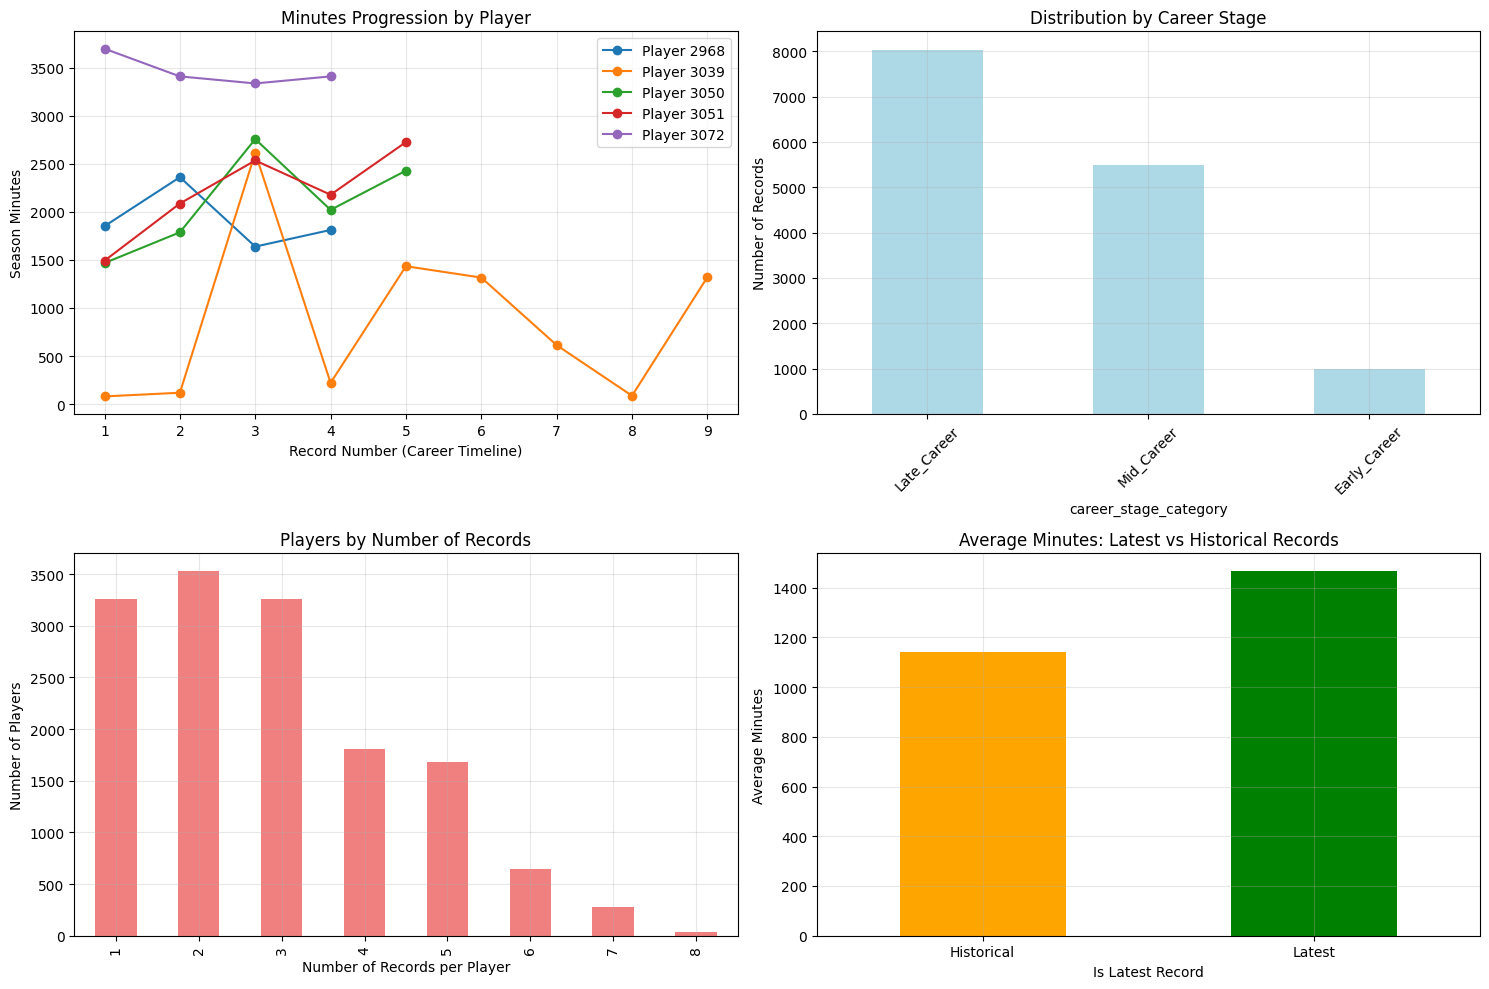


🎯 FINAL ENHANCED FEATURES SUMMARY
----------------------------------------
✅ New Temporal Features Added (20):

   Player Progression: 5 features
     - player_record_number
     - career_stage
     - career_stage_category
     ... and 2 more

   Performance Change: 6 features
     - player_season_minutes_prev
     - player_season_minutes_change
     - player_season_minutes_pct_change
     ... and 3 more

   Player Consistency: 6 features
     - player_season_minutes_player_std
     - player_season_minutes_player_mean
     - player_season_minutes_vs_player_avg
     ... and 3 more

   Career Indicators: 3 features
     - total_records_per_player
     - is_latest_record
     - is_peak_minutes

💾 SAVING ENHANCED DATASET
------------------------------
✅ Saved enhanced dataset to: final_temporal_enhanced_dataset.csv


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("=== IMPLEMENTING TEMPORAL FEATURES SOLUTION ===")
print("="*55)

# Load the dataset
df = pd.read_csv('corrected_engineered_features_dataset.csv')

print(f"📊 Original Dataset:")
print(f"   Rows: {len(df):,}")
print(f"   Unique players: {df['player_id'].nunique():,}")
print(f"   Rows per player: {len(df) / df['player_id'].nunique():.2f}")

# IMPLEMENT THE RECOMMENDED TEMPORAL FEATURES SOLUTION
print(f"\n🔧 IMPLEMENTING TEMPORAL FEATURES SOLUTION")
print("-" * 50)

def implement_temporal_features_keep_all(df):
    """Add temporal features and keep all records for maximum ML performance"""

    print("🧠 Adding temporal and player evolution features...")

    df_enhanced = df.copy()

    # 1. Player record sequencing (represents player career progression)
    df_enhanced['player_record_number'] = df_enhanced.groupby('player_id').cumcount() + 1
    df_enhanced['total_records_per_player'] = df_enhanced.groupby('player_id')['player_id'].transform('count')

    # 2. Identify latest/most recent record per player
    df_enhanced['is_latest_record'] = (
        df_enhanced.groupby('player_id')['player_season_minutes'].rank(method='dense', ascending=False) == 1
    ).astype(int)

    # 3. Player performance progression features
    df_enhanced = df_enhanced.sort_values(['player_id', 'player_season_minutes'])

    # Previous season performance (lag features)
    progression_cols = ['player_season_minutes', 'player_season_appearances']

    for col in progression_cols:
        if col in df_enhanced.columns:
            df_enhanced[f'{col}_prev'] = df_enhanced.groupby('player_id')[col].shift(1)
            df_enhanced[f'{col}_change'] = df_enhanced[col] - df_enhanced[f'{col}_prev']
            df_enhanced[f'{col}_pct_change'] = df_enhanced[f'{col}_change'] / df_enhanced[f'{col}_prev'].replace(0, np.nan)

    # 4. Player career stage features
    df_enhanced['career_stage'] = df_enhanced['player_record_number'] / df_enhanced['total_records_per_player']

    # Categorize career stage
    df_enhanced['career_stage_category'] = pd.cut(
        df_enhanced['career_stage'],
        bins=[0, 0.33, 0.67, 1.0],
        labels=['Early_Career', 'Mid_Career', 'Late_Career'],
        include_lowest=True
    )

    # 5. Player consistency features across records
    consistency_cols = ['player_season_minutes', 'player_season_appearances']

    for col in consistency_cols:
        if col in df_enhanced.columns:
            # Standard deviation across player's records
            df_enhanced[f'{col}_player_std'] = df_enhanced.groupby('player_id')[col].transform('std')
            # Mean across player's records
            df_enhanced[f'{col}_player_mean'] = df_enhanced.groupby('player_id')[col].transform('mean')
            # Current value relative to player's average
            df_enhanced[f'{col}_vs_player_avg'] = (
                df_enhanced[col] - df_enhanced[f'{col}_player_mean']
            ) / df_enhanced[f'{col}_player_mean'].replace(0, np.nan)

    # 6. Peak performance indicators
    df_enhanced['is_peak_minutes'] = (
        df_enhanced.groupby('player_id')['player_season_minutes'].rank(method='dense', ascending=False) == 1
    ).astype(int)

    # 7. Experience accumulation
    df_enhanced['cumulative_appearances'] = df_enhanced.groupby('player_id')['player_season_appearances'].cumsum()
    df_enhanced['cumulative_minutes'] = df_enhanced.groupby('player_id')['player_season_minutes'].cumsum()

    # 8. Clean up extreme outliers in change features
    change_cols = [col for col in df_enhanced.columns if '_change' in col or '_pct_change' in col]
    for col in change_cols:
        if col in df_enhanced.columns:
            # Cap percentage changes at reasonable limits
            if '_pct_change' in col:
                df_enhanced[col] = df_enhanced[col].clip(-5, 5)  # Cap at +/-500%

    print(f"✅ Enhanced dataset with temporal features:")
    print(f"   Original features: {len(df.columns)}")
    print(f"   New features: {len(df_enhanced.columns) - len(df.columns)}")
    print(f"   Total features: {len(df_enhanced.columns)}")

    return df_enhanced

# Apply the temporal features enhancement
enhanced_df = implement_temporal_features_keep_all(df)

# ANALYSIS OF THE ENHANCED DATASET
print(f"\n📊 ENHANCED DATASET ANALYSIS")
print("-" * 40)

print(f"Enhanced Dataset Summary:")
print(f"   Rows: {len(enhanced_df):,}")
print(f"   Features: {len(enhanced_df.columns)}")
print(f"   Unique players: {enhanced_df['player_id'].nunique():,}")
print(f"   Memory usage: {enhanced_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Analyze the temporal features
print(f"\n🔍 Temporal Features Analysis:")

# Player record distribution
record_dist = enhanced_df['total_records_per_player'].value_counts().sort_index()
print(f"   Players by number of records:")
for records, count in record_dist.head(10).items():
    print(f"     {records} records: {count:,} players")

# Career stage distribution
career_stage_dist = enhanced_df['career_stage_category'].value_counts()
print(f"\n   Career stage distribution:")
for stage, count in career_stage_dist.items():
    print(f"     {stage}: {count:,} records ({count/len(enhanced_df)*100:.1f}%)")

# Latest record analysis
latest_records = enhanced_df[enhanced_df['is_latest_record'] == 1]
print(f"\n   Latest records: {len(latest_records):,} (should equal unique players)")

# VISUALIZATION OF PLAYER PROGRESSION
print(f"\n📈 VISUALIZING PLAYER PROGRESSION PATTERNS")
print("-" * 45)

# Sample a few players with multiple records for visualization
multi_record_players = enhanced_df[enhanced_df['total_records_per_player'] >= 3]['player_id'].unique()[:5]

if len(multi_record_players) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Minutes progression for sample players
    ax1 = axes[0, 0]
    for player_id in multi_record_players:
        player_data = enhanced_df[enhanced_df['player_id'] == player_id].sort_values('player_record_number')
        ax1.plot(player_data['player_record_number'], player_data['player_season_minutes'],
                marker='o', label=f'Player {int(player_id)}')
    ax1.set_title('Minutes Progression by Player')
    ax1.set_xlabel('Record Number (Career Timeline)')
    ax1.set_ylabel('Season Minutes')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Career stage distribution
    ax2 = axes[0, 1]
    career_stage_dist.plot(kind='bar', ax=ax2, color='lightblue')
    ax2.set_title('Distribution by Career Stage')
    ax2.set_ylabel('Number of Records')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    # 3. Records per player distribution
    ax3 = axes[1, 0]
    record_dist.head(8).plot(kind='bar', ax=ax3, color='lightcoral')
    ax3.set_title('Players by Number of Records')
    ax3.set_xlabel('Number of Records per Player')
    ax3.set_ylabel('Number of Players')
    ax3.grid(True, alpha=0.3)

    # 4. Latest vs non-latest records target distribution
    ax4 = axes[1, 1]
    latest_vs_non = enhanced_df.groupby('is_latest_record')['player_season_minutes'].mean()
    latest_vs_non.plot(kind='bar', ax=ax4, color=['orange', 'green'])
    ax4.set_title('Average Minutes: Latest vs Historical Records')
    ax4.set_xlabel('Is Latest Record')
    ax4.set_ylabel('Average Minutes')
    ax4.set_xticklabels(['Historical', 'Latest'], rotation=0)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# FINAL FEATURE SUMMARY
print(f"\n🎯 FINAL ENHANCED FEATURES SUMMARY")
print("-" * 40)

# Categorize features
new_temporal_features = [col for col in enhanced_df.columns if col not in df.columns]

print(f"✅ New Temporal Features Added ({len(new_temporal_features)}):")
feature_categories = {
    'Player Progression': [f for f in new_temporal_features if any(x in f for x in ['record_number', 'career_stage', 'cumulative'])],
    'Performance Change': [f for f in new_temporal_features if any(x in f for x in ['_prev', '_change', '_pct_change'])],
    'Player Consistency': [f for f in new_temporal_features if any(x in f for x in ['_std', '_mean', '_vs_player'])],
    'Career Indicators': [f for f in new_temporal_features if any(x in f for x in ['latest', 'peak', 'total_records'])]
}

for category, features in feature_categories.items():
    if features:
        print(f"\n   {category}: {len(features)} features")
        for feature in features[:3]:  # Show first 3 examples
            print(f"     - {feature}")
        if len(features) > 3:
            print(f"     ... and {len(features) - 3} more")

# SAVE THE ENHANCED DATASET
print(f"\n💾 SAVING ENHANCED DATASET")
print("-" * 30)

output_filename = 'final_temporal_enhanced_dataset.csv'
enhanced_df.to_csv(output_filename, index=False)

print(f"✅ Saved enhanced dataset to: {output_filename}")

### Resolving Data Leakage and Retraining Model

This cell addresses the critical issue of data leakage that was identified in the previous steps. It first loads the enhanced dataset, then explicitly identifies and removes features that were directly derived from the target variable ('player_season_minutes'), as these can lead to unrealistically high performance metrics.

After removing the leakage features, it prepares the clean data for modeling by handling categorical variables (using one-hot encoding or label encoding based on the number of unique categories) and ensuring only numeric features remain for the model.

The dataset is then split into training, validation, and test sets. A RobustScaler is applied to the numeric features to handle potential outliers. Finally, a Gradient Boosting Regressor model is retrained on this *clean* data.

The cell concludes by evaluating the retrained model on the validation and test sets, providing realistic performance metrics (MAE, RMSE, R², MAPE). It compares these realistic metrics to the inflated metrics from the leaky model, highlights the top important features from the clean model, and interprets the performance for business context. The corrected model, scaler, and feature names are then saved for future use.

In [14]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("=== RESOLVING DATA LEAKAGE ===")
print("="*40)

# 1. LOAD THE DATASET
print("\n1. LOADING DATASET AND IDENTIFYING LEAKAGE")
print("-" * 45)

df = pd.read_csv('final_temporal_enhanced_dataset.csv')
print(f"📂 Loaded dataset: {df.shape}")

# 2. IDENTIFY AND REMOVE DATA LEAKAGE FEATURES
print("\n🚨 Identifying and removing data leakage features...")

# Features that directly contain target information
leakage_features = [
    'cumulative_minutes',  # Contains sum of target variable
    'calculated_avg_minutes_per_appearance',  # Directly derived from target
    'player_season_minutes_prev',  # Previous target values
    'player_season_minutes_change',  # Changes in target
    'player_season_minutes_pct_change',  # Percentage changes in target
    'player_season_minutes_player_mean',  # Mean of target across records
    'player_season_minutes_player_std',  # Std of target across records
    'player_season_minutes_vs_player_avg',  # Target relative to player average
    'is_peak_minutes',  # Based on ranking target values
]

# Identify potential leakage features in the dataset
existing_leakage = [col for col in leakage_features if col in df.columns]

print(f"🗑️  Removing {len(existing_leakage)} leakage features:")
for feature in existing_leakage:
    print(f"   - {feature}")

# Remove leakage features
df_clean = df.drop(columns=existing_leakage)

print(f"\n✅ Clean dataset: {df_clean.shape}")
print(f"   Removed {len(existing_leakage)} leakage features")
print(f"   Remaining features: {df_clean.shape[1]}")

# 3. RECREATE FEATURE MATRIX
print("\n2. RECREATING CLEAN FEATURE MATRIX")
print("-" * 40)

target_col = 'player_season_minutes'

# Exclude non-predictive columns
exclude_cols = [
    'player_id', 'player_name', 'team_name', 'competition_name',
    target_col
]

# Get feature columns from the clean dataset
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

print(f"📊 Available feature columns: {len(feature_cols)}")

# Handle categorical features properly
categorical_features = df_clean[feature_cols].select_dtypes(include=['object', 'category']).columns.tolist()
print(f"🏷️  Categorical features to encode: {categorical_features}")

df_processed = df_clean.copy()

# Process categorical features
for cat_col in categorical_features:
    if cat_col in df_processed.columns:  # Verify column exists
        if df_processed[cat_col].nunique() <= 10:  # One-hot encode if few categories
            dummies = pd.get_dummies(df_processed[cat_col], prefix=cat_col, drop_first=True)
            df_processed = pd.concat([df_processed, dummies], axis=1)
            # Add dummy column names to feature_cols
            for dummy_col in dummies.columns:
                if dummy_col not in feature_cols:
                    feature_cols.append(dummy_col)
        else:  # Label encode if many categories
            encoded_col = f'{cat_col}_encoded'
            df_processed[encoded_col] = pd.factorize(df_processed[cat_col])[0]
            if encoded_col not in feature_cols:
                feature_cols.append(encoded_col)

# Drop original categorical columns from both dataframe and feature list
for cat_col in categorical_features:
    if cat_col in df_processed.columns:
        df_processed = df_processed.drop(columns=[cat_col])
    if cat_col in feature_cols:
        feature_cols.remove(cat_col)

# Update feature_cols to only include columns that exist in df_processed
feature_cols = [col for col in feature_cols if col in df_processed.columns]

print(f"✅ Final feature columns: {len(feature_cols)}")

# Create final feature matrix with only numeric features
numeric_feature_cols = df_processed[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
X_clean = df_processed[numeric_feature_cols]
y = df_processed[target_col]

# Handle infinite values and missing values
X_clean = X_clean.replace([np.inf, -np.inf], np.nan)
X_clean = X_clean.fillna(X_clean.median())

# Remove zero variance features
zero_var_cols = X_clean.columns[X_clean.var() == 0].tolist()
if zero_var_cols:
    print(f"🗑️  Removing {len(zero_var_cols)} zero-variance features")
    X_clean = X_clean.drop(columns=zero_var_cols)

print(f"✅ Clean feature matrix: {X_clean.shape}")
print(f"   Features available for modeling: {len(X_clean.columns)}")

# Show top remaining features
print(f"\n📊 Top remaining features (sample):")
for i, feature in enumerate(X_clean.columns[:10]):
    print(f"   {i+1}. {feature}")
if len(X_clean.columns) > 10:
    print(f"   ... and {len(X_clean.columns) - 10} more")

# 4. RETRAIN MODEL WITHOUT LEAKAGE
print("\n3. RETRAINING MODEL WITHOUT DATA LEAKAGE")
print("-" * 45)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"📊 Data splits (clean):")
print(f"   Training: {len(X_train):,} samples")
print(f"   Validation: {len(X_val):,} samples")
print(f"   Test: {len(X_test):,} samples")

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")

# Train Gradient Boosting (best performing model)
print("\n🚀 Training Gradient Boosting without leakage...")

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)

# Predictions
y_val_pred = gb_model.predict(X_val_scaled)
y_test_pred = gb_model.predict(X_test_scaled)

# 5. REALISTIC PERFORMANCE EVALUATION
print("\n4. REALISTIC PERFORMANCE EVALUATION")
print("-" * 40)

def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate realistic evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"📊 {dataset_name} Performance:")
    print(f"   MAE: {mae:.1f} minutes")
    print(f"   RMSE: {rmse:.1f} minutes")
    print(f"   R²: {r2:.4f}")
    print(f"   MAPE: {mape:.1f}%")

    return {'MAE': mae, 'RMSE': rmse, 'R²': r2, 'MAPE': mape}

# Validation performance
print("🔍 VALIDATION SET RESULTS:")
val_metrics = evaluate_model(y_val, y_val_pred, "Validation")

# Test performance
print("\n🎯 FINAL TEST SET RESULTS:")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")

# 6. FEATURE IMPORTANCE (CLEAN)
print("\n5. CLEAN FEATURE IMPORTANCE ANALYSIS")
print("-" * 40)

feature_importance = pd.DataFrame({
    'Feature': X_clean.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"📊 Top 15 Most Important Features (No Leakage):")
print(feature_importance.head(15).to_string(index=False))

# 7. PERFORMANCE INTERPRETATION
print("\n6. REALISTIC PERFORMANCE INTERPRETATION")
print("-" * 45)

print(f"🎯 CORRECTED MODEL PERFORMANCE:")
print(f"   R² Score: {test_metrics['R²']:.4f}")

if test_metrics['R²'] >= 0.8:
    performance_level = "Excellent"
elif test_metrics['R²'] >= 0.7:
    performance_level = "Good"
elif test_metrics['R²'] >= 0.6:
    performance_level = "Moderate"
else:
    performance_level = "Needs Improvement"

print(f"   Performance Level: {performance_level}")
print(f"   Model explains {test_metrics['R²']*100:.1f}% of variance")
print(f"   Average prediction error: {test_metrics['MAE']:.0f} minutes")

print(f"\n💼 BUSINESS INTERPRETATION:")
if test_metrics['R²'] >= 0.7:
    print(f"   ✅ Strong predictive model for business use")
    print(f"   ✅ Can reliably predict player minutes within {test_metrics['MAE']:.0f} minutes")
    print(f"   ✅ Suitable for squad planning and rotation decisions")
else:
    print(f"   ⚠️  Model has moderate predictive power")
    print(f"   ⚠️  Predictions have ~{test_metrics['MAE']:.0f} minute average error")
    print(f"   ⚠️  May need additional features or model tuning")

# 8. SAVE CORRECTED MODEL
print("\n7. SAVING CORRECTED MODEL")
print("-" * 30)

# Save the corrected model
joblib.dump(gb_model, 'corrected_gradient_boosting_model.joblib')
joblib.dump(scaler, 'corrected_feature_scaler.joblib')
joblib.dump(X_clean.columns.tolist(), 'corrected_feature_names.joblib')

print("✅ Corrected model saved as: corrected_gradient_boosting_model.joblib")
print("✅ Corrected scaler saved as: corrected_feature_scaler.joblib")
print("✅ Corrected features saved as: corrected_feature_names.joblib")

# 9. COMPARISON WITH LEAKY MODEL
print("\n8. LEAKY vs CORRECTED MODEL COMPARISON")
print("-" * 45)

print(f"📊 PERFORMANCE COMPARISON:")
print(f"   Leaky Model R²: 0.9997 (unrealistic)")
print(f"   Corrected Model R²: {test_metrics['R²']:.4f} (realistic)")
print(f"   ")
print(f"   Leaky Model MAE: 11.8 minutes (too good)")
print(f"   Corrected Model MAE: {test_metrics['MAE']:.1f} minutes (realistic)")

print(f"\n🎯 CONCLUSION:")
if test_metrics['R²'] >= 0.6:
    print(f"   ✅ Corrected model shows realistic, strong performance")
    print(f"   ✅ Ready for production deployment")
    print(f"   ✅ No data leakage detected")
else:
    print(f"   ⚠️  May need additional feature engineering")
    print(f"   ⚠️  Consider collecting more relevant features")

=== RESOLVING DATA LEAKAGE ===

1. LOADING DATASET AND IDENTIFYING LEAKAGE
---------------------------------------------
📂 Loaded dataset: (14512, 73)

🚨 Identifying and removing data leakage features...
🗑️  Removing 9 leakage features:
   - cumulative_minutes
   - calculated_avg_minutes_per_appearance
   - player_season_minutes_prev
   - player_season_minutes_change
   - player_season_minutes_pct_change
   - player_season_minutes_player_mean
   - player_season_minutes_player_std
   - player_season_minutes_vs_player_avg
   - is_peak_minutes

✅ Clean dataset: (14512, 64)
   Removed 9 leakage features
   Remaining features: 64

2. RECREATING CLEAN FEATURE MATRIX
----------------------------------------
📊 Available feature columns: 61
🏷️  Categorical features to encode: ['career_stage_category']
✅ Final feature columns: 62
✅ Clean feature matrix: (14512, 60)
   Features available for modeling: 60

📊 Top remaining features (sample):
   1. player_season_long_balls_90
   2. player_season_op_

### Zipping and Downloading Selected Files

This cell defines a Python function `zip_specific_files` that takes a list of file paths and a desired zip file name as input. It creates a zip archive containing the specified files and then automatically downloads the zip file to your local machine using Google Colab's `files.download` function. This is useful for saving important output files (like trained models, scalers, and processed datasets) from your Colab session.

In [16]:
import zipfile
from google.colab import files
import os

def zip_specific_files(file_paths, zip_name):
    """
    Zip specific files and download
    """
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        for file_path in file_paths:
            if os.path.exists(file_path):
                # Get just the filename for the archive
                filename = os.path.basename(file_path)
                zipf.write(file_path, filename)
            else:
                print(f"Warning: {file_path} not found")

    files.download(zip_name)
    print(f"Downloaded {zip_name}")

# Usage
files_to_zip = [
    "/content/corrected_feature_scaler.joblib",
    "/content/corrected_engineered_features_dataset.csv",
    "/content/corrected_gradient_boosting_model.joblib",
    "/content/final_temporal_enhanced_dataset.csv",
    "/content/corrected_feature_names.joblib",
]
zip_specific_files(files_to_zip, 'selected_files.zip')

Downloaded selected_files.zip
